In [175]:
import numpy as np
from matplotlib import pyplot as plt, rcParams
import torch
import torch.optim as optim
import torch.nn as nn
from matplotlib.colors import LogNorm

from jupyterthemes import jtplot
plt.style.use('dark_background')
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
np.random.seed(42)
rcParams['axes.facecolor'] = 'k'
rcParams["figure.facecolor"] = '#212121'
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.serif"] = "Bitstream Vera Serif"
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = False


# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

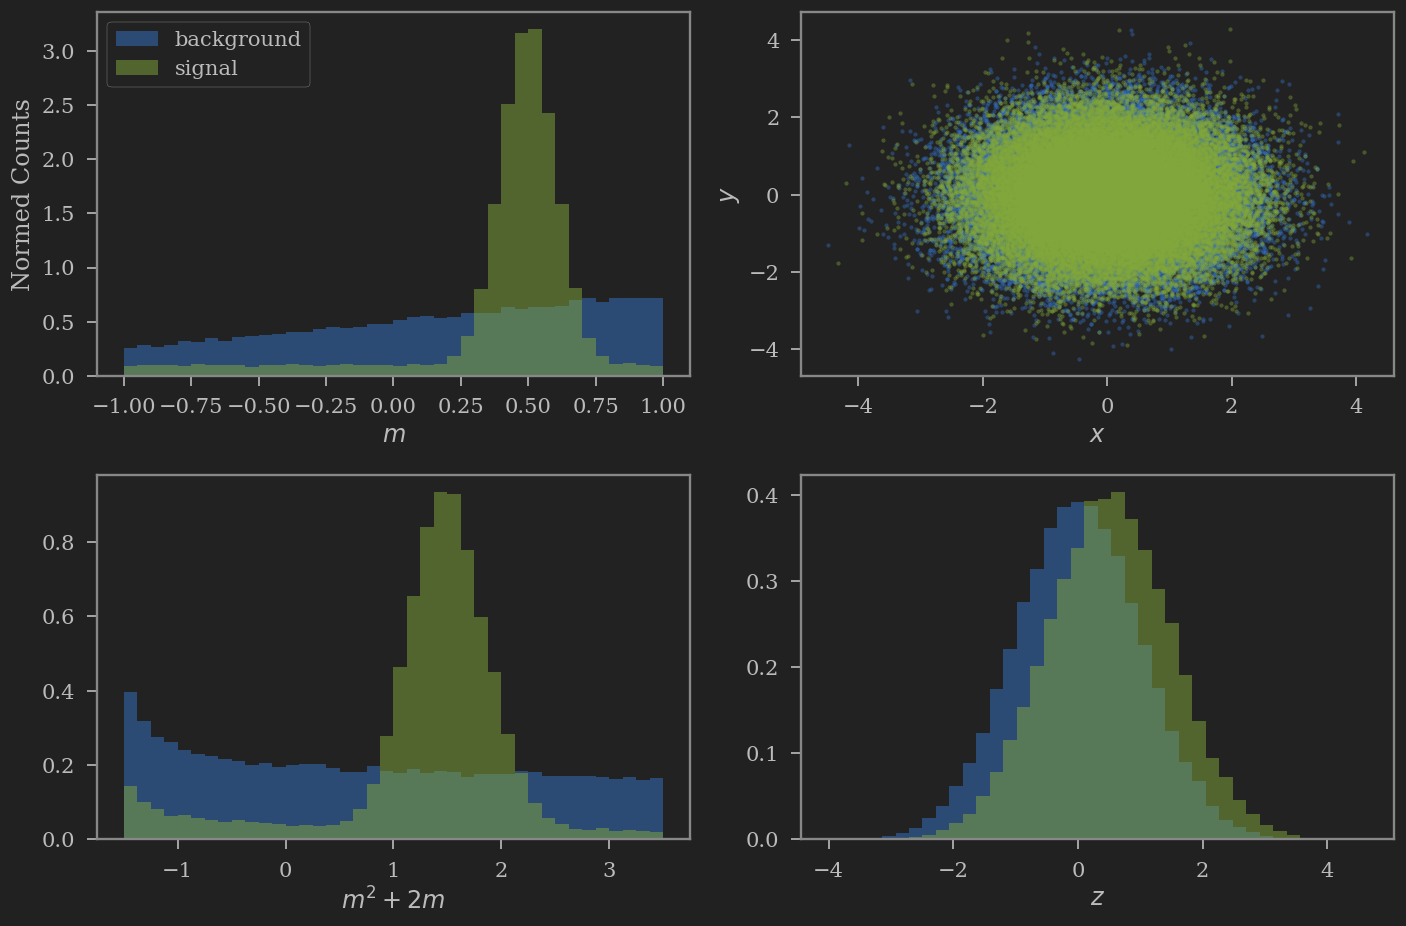

In [419]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,50000)
u_ = np.random.uniform(0,1,50000)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

_,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax1.legend()
ax1.set_xlabel(r"$m$")
ax1.set_ylabel("Normed Counts")

ax2.scatter(x_b,y_b,s=5,alpha=0.4)
ax2.scatter(x_s,y_s,s=5,alpha=0.4)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")

_,bins,_ = ax3.hist(m_b**2+2.5*m_b,bins=40,density=True,alpha=0.5, label='background')
ax3.hist(m_s**2+2.5*m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax3.set_xlabel(r"$m^2 + 2m$")

_,bins,_ = ax4.hist(z_b,bins=40,density=True,alpha=0.5, label='background')
ax4.hist(z_s,bins=bins,density=True,alpha=0.5,label='signal')
ax4.set_xlabel(r"$z$")

#ax2.set_title("Data")
fig.tight_layout()
plt.savefig("./plots/Data.pdf")
plt.show()

In [420]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])
    
#x = np.concatenate([m_s,m_b])
y = np.concatenate([np.ones(m_s.size),np.zeros(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) #,x_test,y_test
y_test = np.zeros(n_b)
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]

# Torch Tensors
x_train_tensor = torch.from_numpy(x_train).float().view(-1,5)
y_train_tensor = torch.from_numpy(y_train).float().view(-1,1)
x_val_tensor = torch.from_numpy(x_val).float().view(-1,5)
y_val_tensor = torch.from_numpy(y_val).float().view(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().view(-1,5)
y_test_tensor = torch.from_numpy(y_test).float().view(-1,1)

In [279]:

# Creating the torch model
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,16)
        self.linear2 = nn.Linear(16,32)
        self.out = nn.Linear(32,1)
        # Defaults
        self.n_epochs = 200
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-1)
        self.yhat_val = None
        self.yhat = None
        #self.loss = torch.nn.MSELoss()
        
    def forward(self, x):
        x = nn.functional.relu(self.linear(x))
        x = nn.functional.relu(self.linear2(x))
        x = torch.sigmoid(self.out(x))
        return x
    
    def fit(self,x,y,n_epochs=None,optimizer=None,loss=None,interval=100,val_data=[],metrics=[],delay_loss=False):
        if n_epochs: 
            self.n_epochs = n_epochs
        if optimizer: 
            self.optimizer = optimizer
        if loss:
            self.loss = loss
        for epoch in range(self.n_epochs):
            self.train()
            self.yhat = self(x)
            if epoch<delay_loss:
                l = torch.nn.MSELoss()(self.yhat,y)
            else:
                l = self.loss(self.yhat,y)
            l.backward()    
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if metrics:
                if type(metrics) == list:
                    metrics[0].calculate(pred=self.yhat,target=y)
                else:
                    metrics.calculate(pred=self.yhat,target=y,l=l.item())

        #Validation and Printing
            if val_data:
                if epoch % interval ==0 or epoch == self.n_epochs-1:
                    self.train(False)
                    self.yhat_val = self(val_data[0])
                    l_val = torch.nn.MSELoss()(self.yhat_val,val_data[1] )
                    if len(metrics)>1:
                        metrics[1].calculate(pred=self.yhat_val,target=val_data[1],l=l_val.item())
                    acc = metrics[0].accs[-1]
                    acc_val = metrics[1].accs[-1]
                    print('Epoch:{:04d}/{:04d} || Train: loss:{:.4f}, acc:{:.0f}% || Test: loss: {:.4f}, acc:{:.0f}%'.format(
                    epoch,n_epochs,l.item(), 100.* acc,
                    l_val.item(), 100.* acc_val))
            else:
                if epoch % interval ==0:
                    acc = metrics[0].accs[-1]
                    print('Epoch:{:04d}/{:04d} loss: {:.4f}, accuracy:({:.0f}%)'.format(
                        epoch,n_epochs,l.item(), 100.* acc))
                
    
#define some lists to fill
class Metrics():
    def __init__(self):
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
    def calculate(self,pred,target,l=None,validation=False):
        acc = (pred.round()==target).sum().item()/target.shape[0]
        signal_efficiency = ((pred.round()==target)&(target==1)).sum().item()/(target==1).sum().item()
        background_efficiency = ((pred.round()==target)&(target==0)).sum().item()/(target==0).sum().item()
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
            

In [443]:
class LegendreLoss():
    def __init__(self,x_biased,frac=0.9):
        self.frac = frac
        self.mass = np.sort(x_biased)
        self.ordered_mass = np.argsort(x_biased)
        self.dm = torch.from_numpy(self.mass.reshape(-1,100)[:,-1] - self.mass.reshape(-1,100)[:,0]).float().view(-1,1)
        self.m = torch.from_numpy(self.mass.reshape(-1,100).mean(axis=1)).float().view(-1,1)
        self.p0 = 1
        self.p1 = self.m
        self.p2 = (self.m**2-1)/2
        self.scores = 0
        self.legendre = 0
    def __call__(self,pred,target):   
        pred_bins = pred[self.ordered_mass].reshape(-1,100)
        ordered_s = pred_bins.argsort(axis=1)
        self.scores = pred_bins #pred_bins.gather(1,ordered_s) # ordered in mass bins in axis 0 and ordered in score in axis 1
        self.scores = torch.cumsum(self.scores,axis=1)/self.scores.sum(axis=1).view(-1,1)
        a0 = 1/2 * (self.scores*self.dm).sum(axis=0)
        a1 = 3/2 * (self.scores*self.p1*self.dm).sum(axis=0)
        #mean = pred[self.ordered].reshape(-1,100).mean(axis=1)
        #a0 = 1/2 * (mean*self.dm).sum()
        #a1 = 3/2 * (mean*self.p1*self.dm).sum()
        #a2 = 5/2 * (mean*self.p2*self.dm).sum()
        self.legendre = a0 + a1*self.p1 #+ a2*self.p2
        legendre_loss = ((self.scores - self.legendre)**2).mean()
        return legendre_loss*self.frac + torch.nn.MSELoss()(pred,target)*(1-self.frac)

    
class JiangLoss():
    def __init__(self,truth,x_biased,eta=1e-3,range=(0.25,0.75)):
        self.gx = (x_biased<rang[1])&(x_biased>range[0])
        self.ytrue = (truth==1)
        self.Z_g = self.gx.sum()/x_biased.size
        self.P_g = (self.ytrue&self.gx).sum()/x_biased.size
        self.P_x = (self.ytrue).sum()/x_biased.size
        self.cx = (self.gx/self.Z_g -1)
        self.lambda1 = 0
        self.weights = np.ones_like(y_train)
        self.eta = eta #1e-3
        self.scores = torch.from_numpy(np.random.randint(0,2,size=x_biased.size))
    def __call__(self,pred,target):
        self.weights = np.array(self.weights.tolist()).flatten()
        self.delta =  (np.array(self.scores.tolist()).flatten()*self.cx).mean()      # +(1-yhat)*0
        self.lambda1 -= self.eta*self.delta
        weights_ = np.exp(self.lambda1*self.cx)
        self.weights[y_train==1] = (weights_/(1+weights_))[y_train==1]
        self.weights[y_train==0] = (1/(1+weights_))[y_train==0]
        self.weights = torch.from_numpy(self.weights).view(-1,1)
        self.scores = pred
        return torch.mean(self.weights*(pred-target)**2)

In [235]:
metrics_train_base = Metrics()
metrics_val_base = Metrics()
model_base = Classifier()
model_base.loss = torch.nn.MSELoss()
model_base.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=2000,
               metrics=[metrics_train_base,metrics_val_base], 
               val_data=[x_val_tensor[:,1:],y_val_tensor])

print(metrics_val_base.accs[-1])
print(metrics_val_base.signalE[-1])
print(metrics_val_base.backgroundE[-1])

Epoch:0000/2000 || Train: loss:0.2518, acc:42% || Test: loss: 0.2515, acc:43%
Epoch:0100/2000 || Train: loss:0.2408, acc:64% || Test: loss: 0.2409, acc:64%
Epoch:0200/2000 || Train: loss:0.2331, acc:65% || Test: loss: 0.2332, acc:65%
Epoch:0300/2000 || Train: loss:0.2264, acc:65% || Test: loss: 0.2267, acc:65%
Epoch:0400/2000 || Train: loss:0.2200, acc:66% || Test: loss: 0.2206, acc:66%
Epoch:0500/2000 || Train: loss:0.2129, acc:68% || Test: loss: 0.2139, acc:67%
Epoch:0600/2000 || Train: loss:0.2048, acc:70% || Test: loss: 0.2062, acc:69%
Epoch:0700/2000 || Train: loss:0.1964, acc:72% || Test: loss: 0.1983, acc:71%
Epoch:0800/2000 || Train: loss:0.1886, acc:74% || Test: loss: 0.1908, acc:73%
Epoch:0900/2000 || Train: loss:0.1821, acc:75% || Test: loss: 0.1846, acc:75%
Epoch:1000/2000 || Train: loss:0.1772, acc:76% || Test: loss: 0.1799, acc:75%
Epoch:1100/2000 || Train: loss:0.1737, acc:77% || Test: loss: 0.1766, acc:76%
Epoch:1200/2000 || Train: loss:0.1713, acc:77% || Test: loss: 0.

No handles with labels found to put in legend.
/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


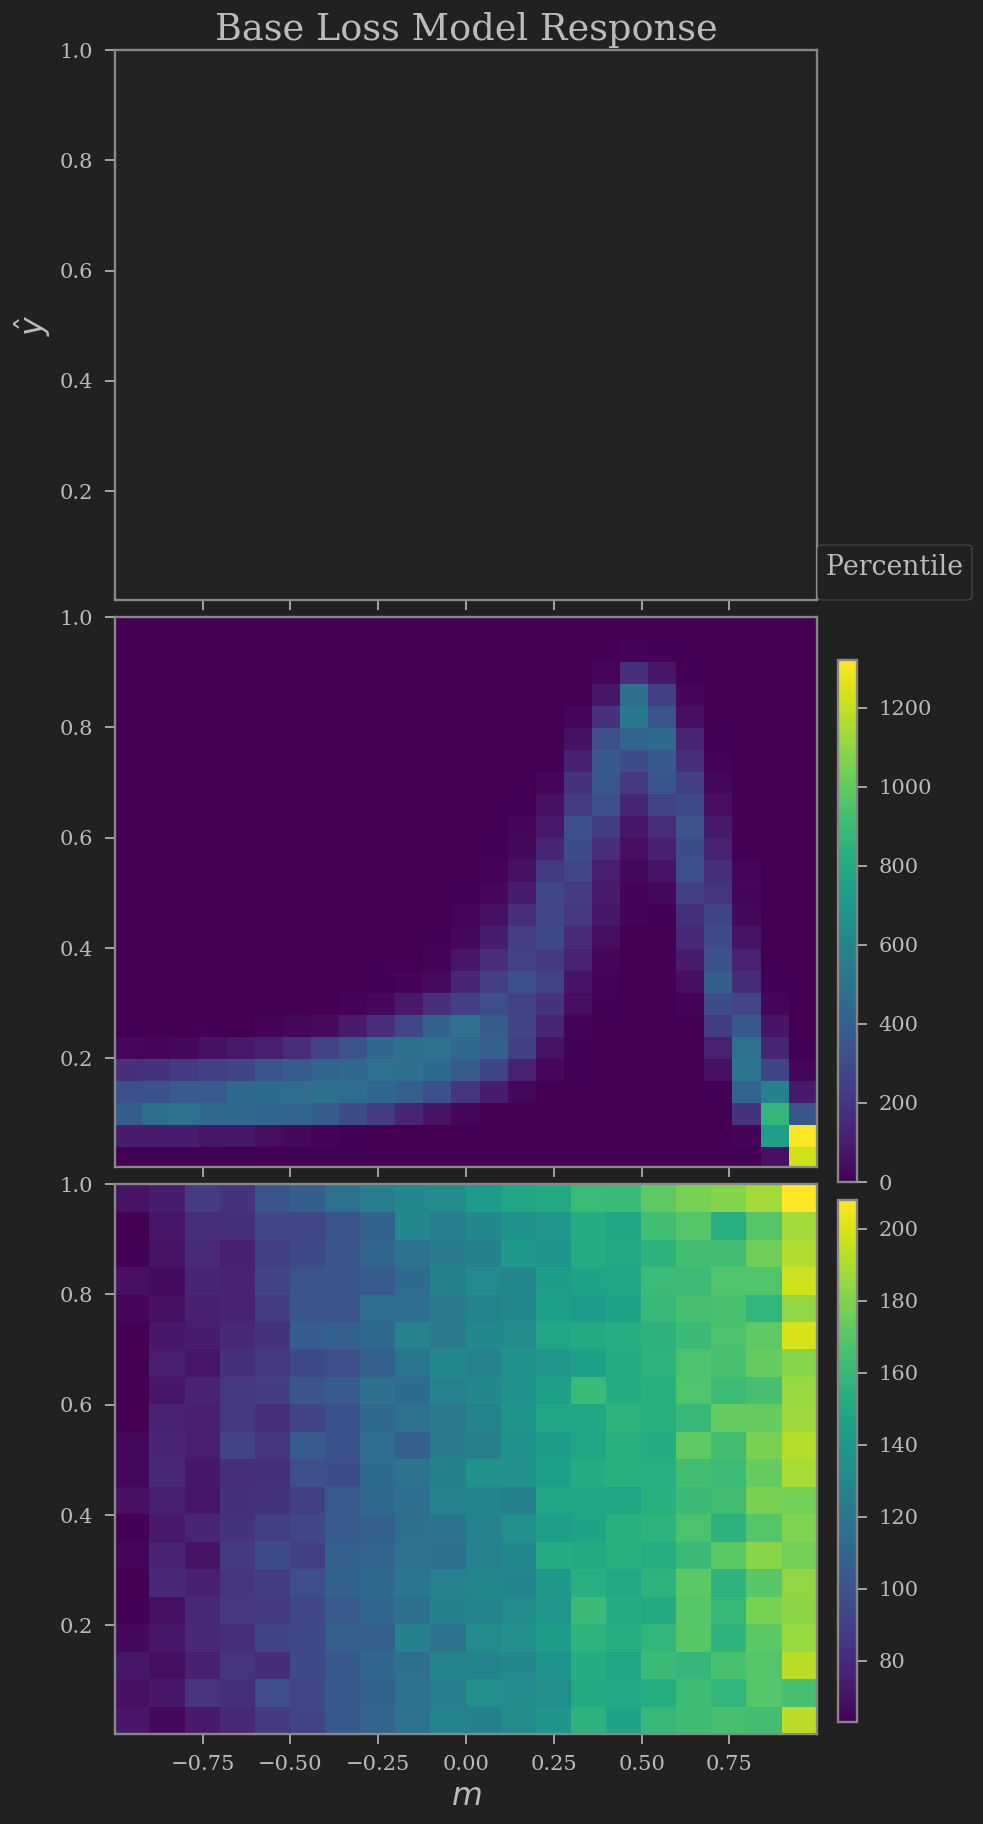

In [444]:
scores = np.array(model_base(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score_mask = scores.argsort(axis=1)#0
scores_ordered = scores#[np.arange(scores.shape[0])[:, None], ordered_score_mask]
m_ordered_score = m_t.reshape(-1,100)#[np.arange(scores.shape[0])[:, None], ordered_score_mask]
Fs = scores_ordered.cumsum(axis=1)/scores_ordered.sum(axis=1).reshape(-1,1)

fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True,sharey=True)
# for j,i in enumerate(range(10,scores_ordered.shape[1],10)):
#     c = f"C{j}" if j!= 6 else f"C11"
#     ax1.scatter(m,scores_ordered[:,i],label=f"{int(i*100/scores.shape[1])}",alpha=0.7,s=2,c=c)

    #plt.plot(m,base[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
ax1.set_ylabel(r"$\hat{y}$",fontsize=19)
ax1.set_title("Base Loss Model Response",fontsize=22)
ax1.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)

counts,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",range=[(-1,1),(0,1)])#norm=LogNorm())
cbaxes = fig.add_axes([0.86, 0.35, 0.02, 0.29]) 
plt.colorbar(h,ax=ax2,cax = cbaxes)

_,_,_,h = ax3.hist2d(m_ordered_score.flatten(),Fs.flatten(),bins=20, label="all")#norm=LogNorm())
cbaxes = fig.add_axes([0.86, 0.05, 0.02, 0.29]) 
plt.colorbar(h,ax=ax3,cax = cbaxes)
ax3.set_xlabel(r"$m$",fontsize=19)


fig.tight_layout(pad=0)
plt.show()

In [348]:
from scipy.optimize import minimize
def fun(cut,signalE):
        passing_cut = (validation_predictions>cut).astype(int)
        return abs(((passing_cut==y_val)&(y_val==1)).sum()/(y_val==1).sum()-signalE)
def get_cuts(signalEs):
    cuts =[]
    for signalE in signalEs:
        cuts.append(minimize(fun,[0.5],args=(signalE),method="Nelder-mead",bounds=(0,1)).x[0])
    return cuts

Epoch:0000/1700 || Train: loss:0.2490, acc:52% || Test: loss: 0.2490, acc:53%
Epoch:0100/1700 || Train: loss:0.2349, acc:63% || Test: loss: 0.2345, acc:63%
Epoch:0200/1700 || Train: loss:0.2215, acc:67% || Test: loss: 0.2207, acc:68%
Epoch:0300/1700 || Train: loss:0.2112, acc:69% || Test: loss: 0.2100, acc:69%
Epoch:0400/1700 || Train: loss:0.2038, acc:70% || Test: loss: 0.2022, acc:70%
Epoch:0500/1700 || Train: loss:0.1978, acc:71% || Test: loss: 0.1960, acc:72%
Epoch:0600/1700 || Train: loss:0.1926, acc:73% || Test: loss: 0.1906, acc:73%
Epoch:0700/1700 || Train: loss:0.1881, acc:74% || Test: loss: 0.1860, acc:74%
Epoch:0800/1700 || Train: loss:0.1842, acc:75% || Test: loss: 0.1821, acc:75%
Epoch:0900/1700 || Train: loss:0.1808, acc:76% || Test: loss: 0.1788, acc:76%
Epoch:1000/1700 || Train: loss:0.1780, acc:76% || Test: loss: 0.1760, acc:76%
Epoch:1100/1700 || Train: loss:0.1757, acc:76% || Test: loss: 0.1737, acc:77%
Epoch:1200/1700 || Train: loss:0.1737, acc:77% || Test: loss: 0.

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


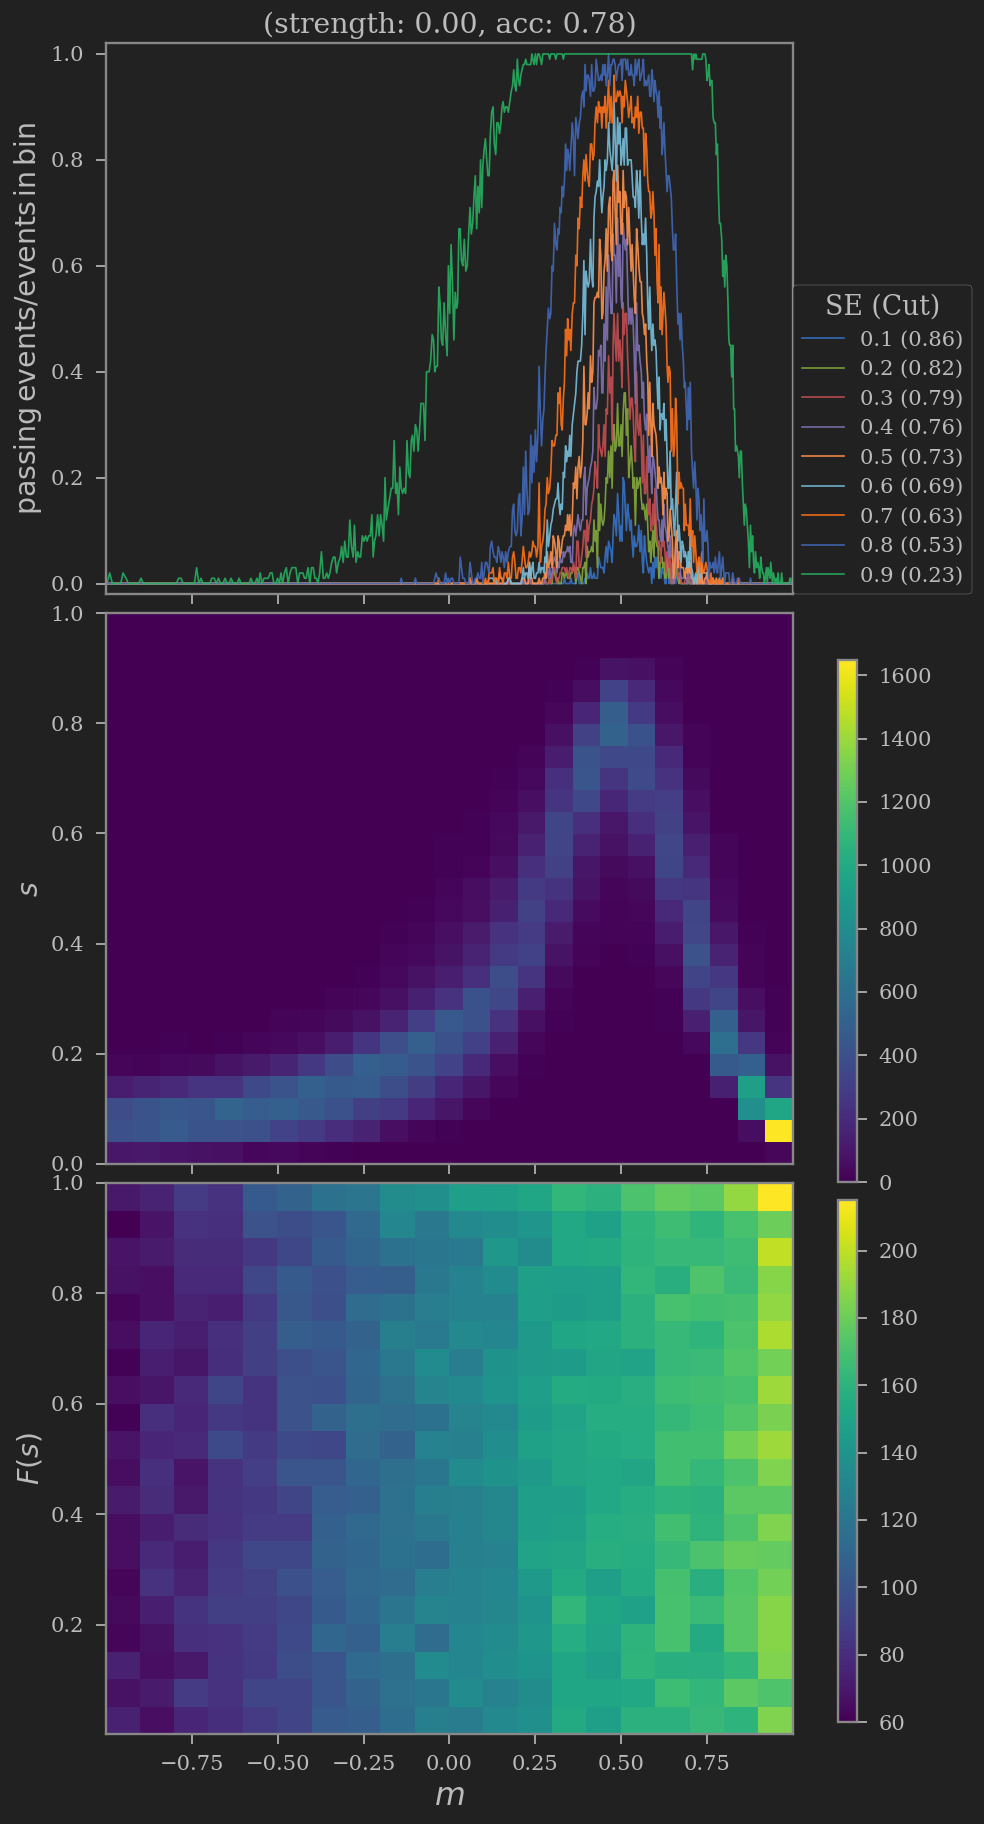

Epoch:0000/1700 || Train: loss:0.1736, acc:50% || Test: loss: 0.2590, acc:50%
Epoch:0100/1700 || Train: loss:0.1590, acc:66% || Test: loss: 0.2381, acc:66%
Epoch:0200/1700 || Train: loss:0.1519, acc:66% || Test: loss: 0.2273, acc:66%
Epoch:0300/1700 || Train: loss:0.1465, acc:67% || Test: loss: 0.2189, acc:66%
Epoch:0400/1700 || Train: loss:0.1431, acc:67% || Test: loss: 0.2134, acc:67%
Epoch:0500/1700 || Train: loss:0.1406, acc:68% || Test: loss: 0.2095, acc:68%
Epoch:0600/1700 || Train: loss:0.1385, acc:68% || Test: loss: 0.2060, acc:68%
Epoch:0700/1700 || Train: loss:0.1364, acc:69% || Test: loss: 0.2028, acc:69%
Epoch:0800/1700 || Train: loss:0.1344, acc:70% || Test: loss: 0.1996, acc:71%
Epoch:0900/1700 || Train: loss:0.1325, acc:71% || Test: loss: 0.1965, acc:72%
Epoch:1000/1700 || Train: loss:0.1305, acc:72% || Test: loss: 0.1936, acc:72%
Epoch:1100/1700 || Train: loss:0.1287, acc:72% || Test: loss: 0.1908, acc:73%
Epoch:1200/1700 || Train: loss:0.1269, acc:73% || Test: loss: 0.

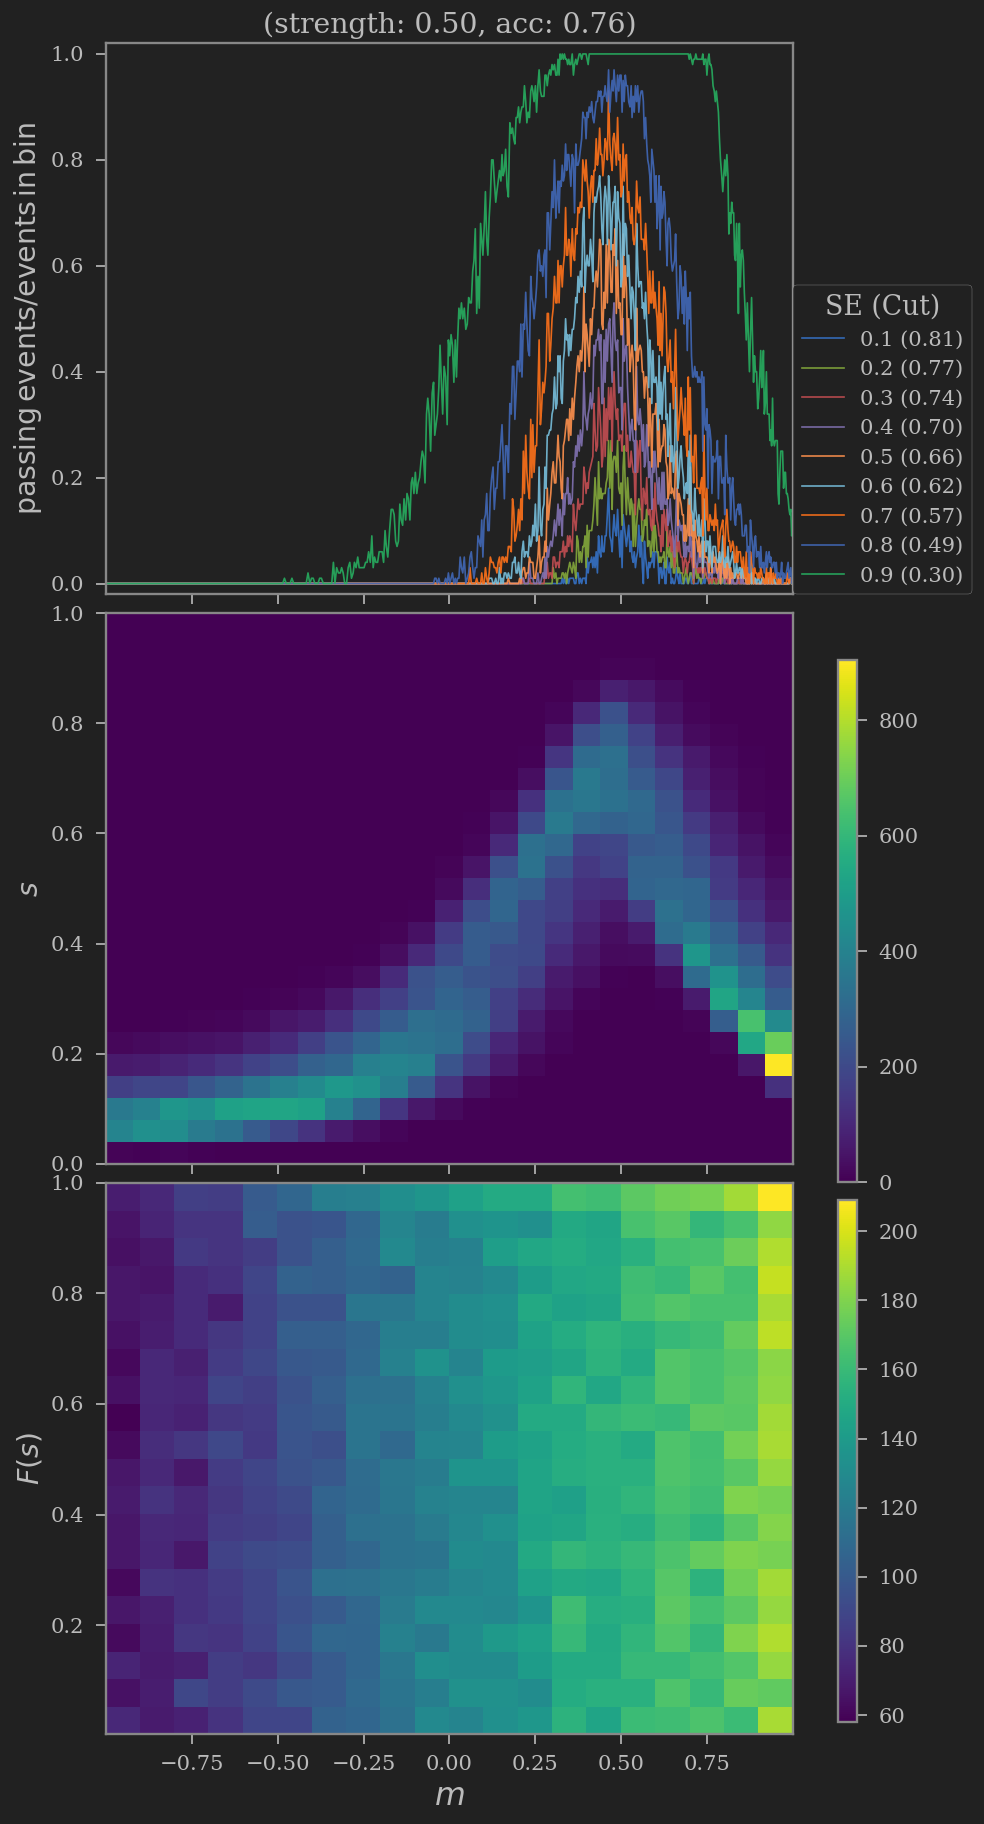

Epoch:0000/1700 || Train: loss:0.1300, acc:50% || Test: loss: 0.2590, acc:50%
Epoch:0100/1700 || Train: loss:0.1221, acc:64% || Test: loss: 0.2441, acc:63%
Epoch:0200/1700 || Train: loss:0.1192, acc:64% || Test: loss: 0.2383, acc:65%
Epoch:0300/1700 || Train: loss:0.1165, acc:65% || Test: loss: 0.2327, acc:65%
Epoch:0400/1700 || Train: loss:0.1140, acc:65% || Test: loss: 0.2277, acc:65%
Epoch:0500/1700 || Train: loss:0.1120, acc:66% || Test: loss: 0.2233, acc:66%
Epoch:0600/1700 || Train: loss:0.1103, acc:66% || Test: loss: 0.2198, acc:66%
Epoch:0700/1700 || Train: loss:0.1090, acc:66% || Test: loss: 0.2169, acc:66%
Epoch:0800/1700 || Train: loss:0.1077, acc:67% || Test: loss: 0.2142, acc:67%
Epoch:0900/1700 || Train: loss:0.1066, acc:67% || Test: loss: 0.2118, acc:67%
Epoch:1000/1700 || Train: loss:0.1054, acc:68% || Test: loss: 0.2093, acc:68%
Epoch:1100/1700 || Train: loss:0.1042, acc:68% || Test: loss: 0.2069, acc:69%
Epoch:1200/1700 || Train: loss:0.1030, acc:69% || Test: loss: 0.

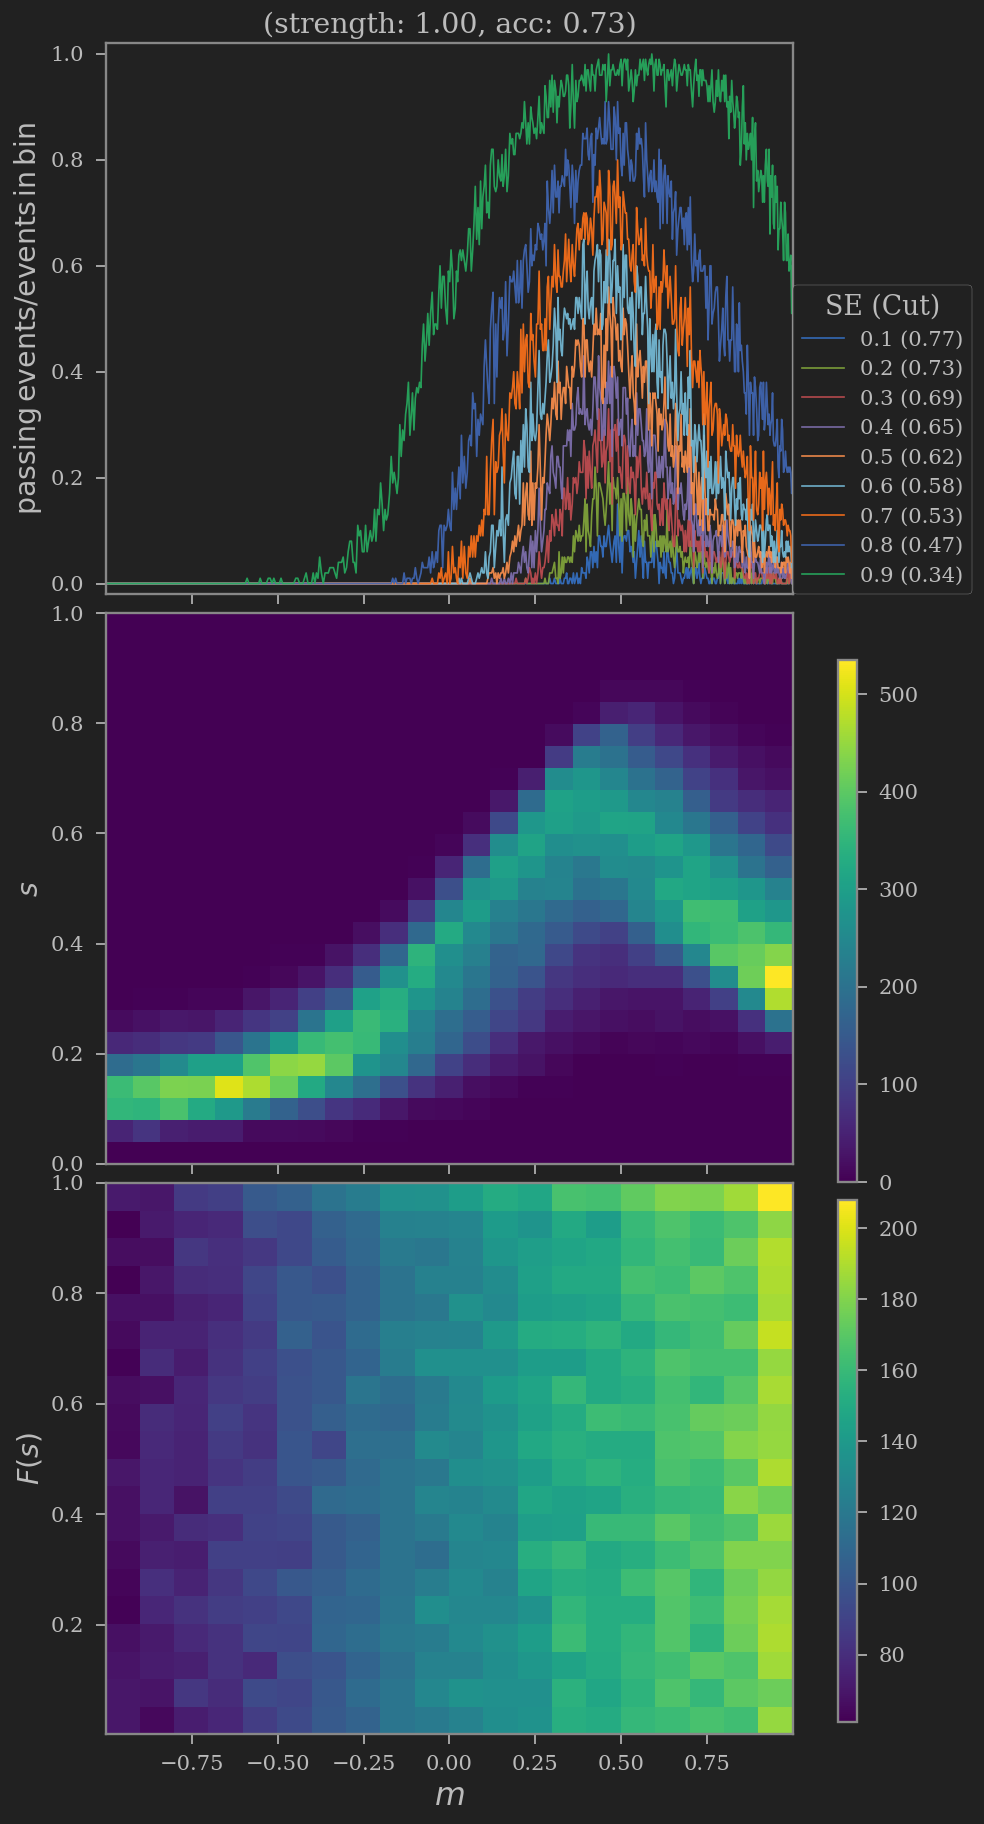

Epoch:0000/1700 || Train: loss:0.0841, acc:50% || Test: loss: 0.2515, acc:50%
Epoch:0100/1700 || Train: loss:0.0815, acc:60% || Test: loss: 0.2443, acc:61%
Epoch:0200/1700 || Train: loss:0.0802, acc:64% || Test: loss: 0.2404, acc:65%
Epoch:0300/1700 || Train: loss:0.0791, acc:64% || Test: loss: 0.2369, acc:65%
Epoch:0400/1700 || Train: loss:0.0780, acc:65% || Test: loss: 0.2335, acc:65%
Epoch:0500/1700 || Train: loss:0.0769, acc:65% || Test: loss: 0.2300, acc:66%
Epoch:0600/1700 || Train: loss:0.0758, acc:65% || Test: loss: 0.2268, acc:66%
Epoch:0700/1700 || Train: loss:0.0749, acc:65% || Test: loss: 0.2237, acc:66%
Epoch:0800/1700 || Train: loss:0.0740, acc:66% || Test: loss: 0.2209, acc:66%
Epoch:0900/1700 || Train: loss:0.0732, acc:66% || Test: loss: 0.2182, acc:67%
Epoch:1000/1700 || Train: loss:0.0724, acc:67% || Test: loss: 0.2158, acc:67%
Epoch:1100/1700 || Train: loss:0.0717, acc:67% || Test: loss: 0.2134, acc:68%
Epoch:1200/1700 || Train: loss:0.0710, acc:68% || Test: loss: 0.

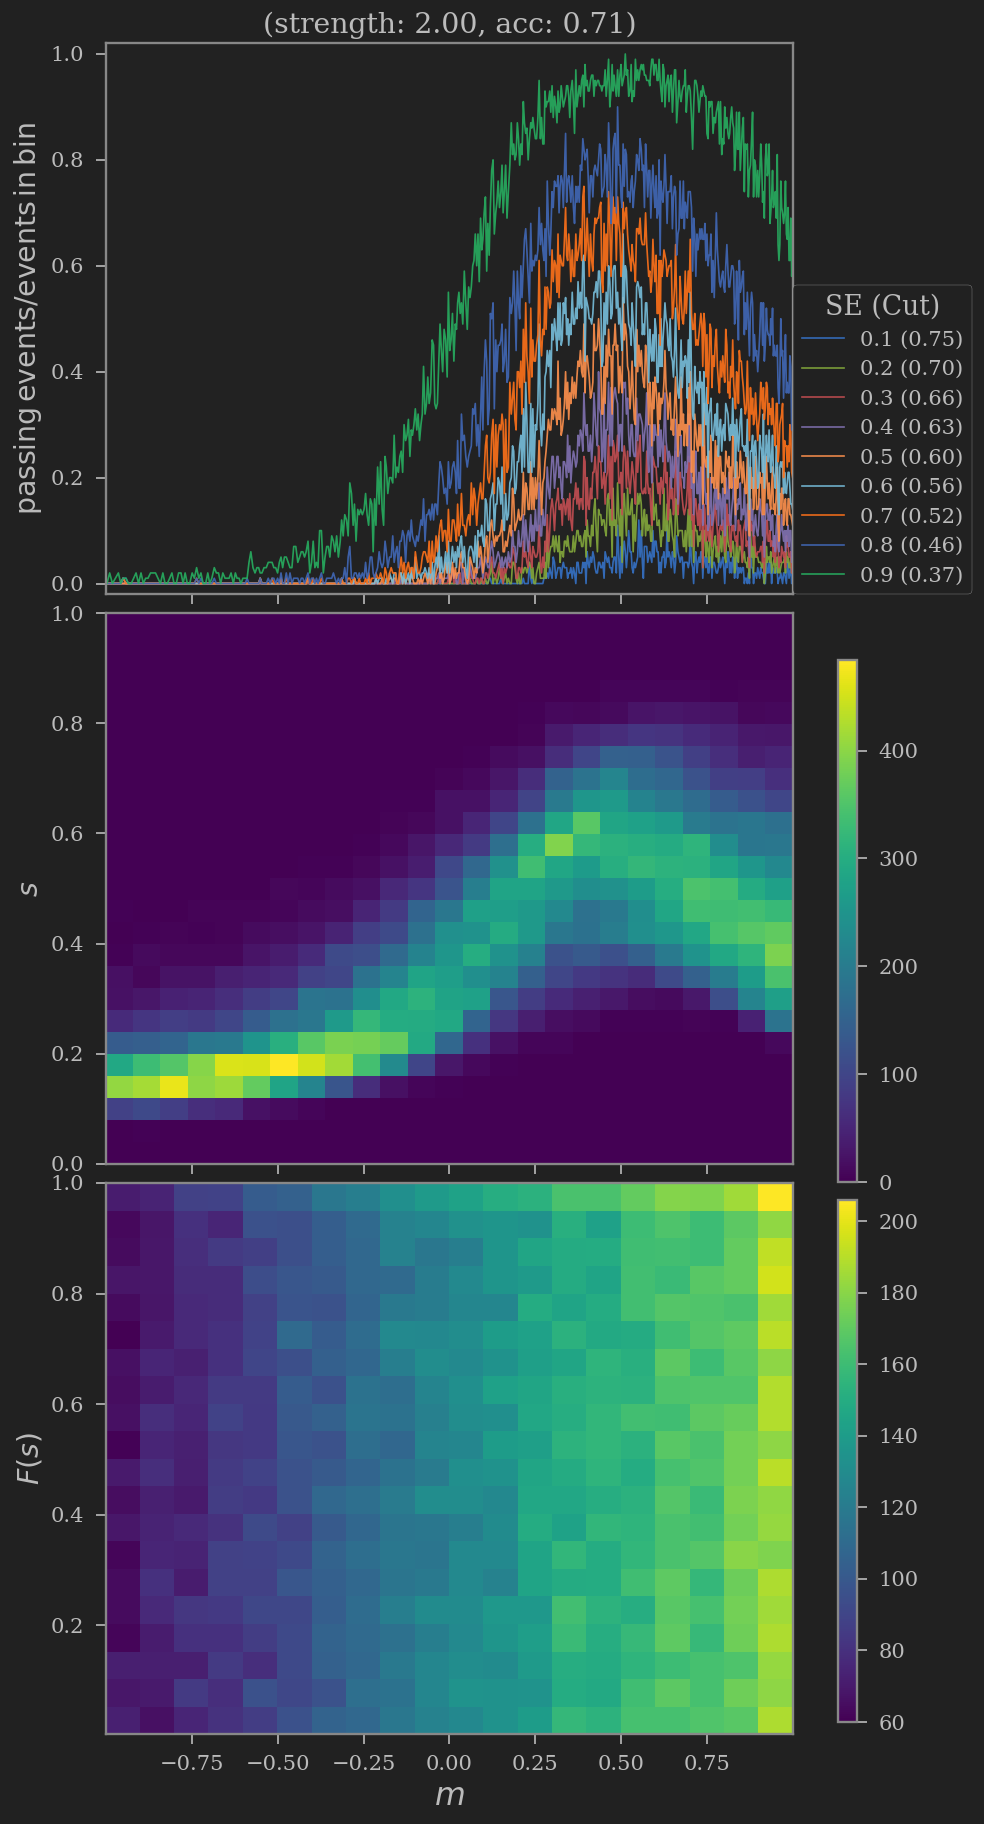

Epoch:0000/1700 || Train: loss:0.0618, acc:50% || Test: loss: 0.2474, acc:50%
Epoch:0100/1700 || Train: loss:0.0611, acc:53% || Test: loss: 0.2444, acc:53%
Epoch:0200/1700 || Train: loss:0.0604, acc:63% || Test: loss: 0.2416, acc:63%
Epoch:0300/1700 || Train: loss:0.0598, acc:65% || Test: loss: 0.2388, acc:65%
Epoch:0400/1700 || Train: loss:0.0591, acc:65% || Test: loss: 0.2362, acc:66%
Epoch:0500/1700 || Train: loss:0.0585, acc:66% || Test: loss: 0.2336, acc:66%
Epoch:0600/1700 || Train: loss:0.0580, acc:66% || Test: loss: 0.2312, acc:66%
Epoch:0700/1700 || Train: loss:0.0574, acc:66% || Test: loss: 0.2288, acc:66%
Epoch:0800/1700 || Train: loss:0.0568, acc:66% || Test: loss: 0.2265, acc:66%
Epoch:0900/1700 || Train: loss:0.0563, acc:66% || Test: loss: 0.2243, acc:66%
Epoch:1000/1700 || Train: loss:0.0558, acc:66% || Test: loss: 0.2223, acc:66%
Epoch:1100/1700 || Train: loss:0.0554, acc:66% || Test: loss: 0.2204, acc:67%
Epoch:1200/1700 || Train: loss:0.0550, acc:67% || Test: loss: 0.

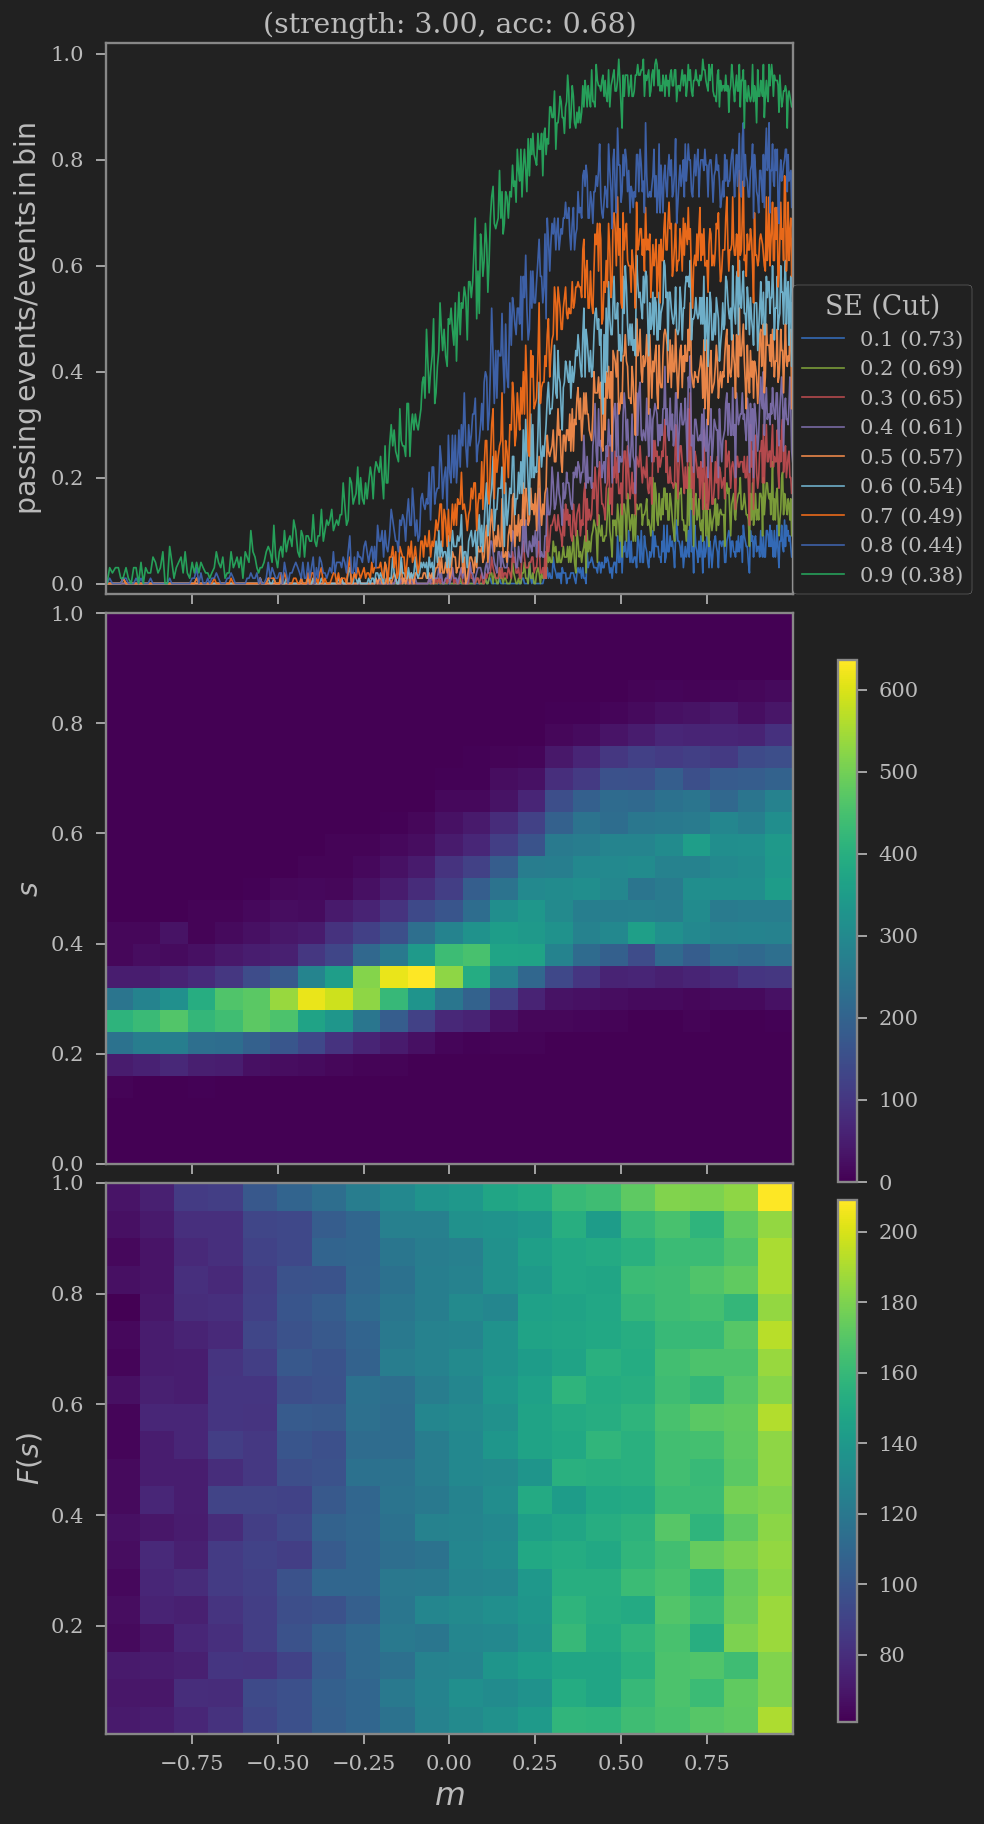

Epoch:0000/1700 || Train: loss:0.0420, acc:49% || Test: loss: 0.2517, acc:48%
Epoch:0100/1700 || Train: loss:0.0417, acc:52% || Test: loss: 0.2499, acc:51%
Epoch:0200/1700 || Train: loss:0.0414, acc:55% || Test: loss: 0.2484, acc:55%
Epoch:0300/1700 || Train: loss:0.0412, acc:57% || Test: loss: 0.2468, acc:57%
Epoch:0400/1700 || Train: loss:0.0409, acc:60% || Test: loss: 0.2453, acc:59%
Epoch:0500/1700 || Train: loss:0.0407, acc:61% || Test: loss: 0.2438, acc:61%
Epoch:0600/1700 || Train: loss:0.0404, acc:62% || Test: loss: 0.2423, acc:62%
Epoch:0700/1700 || Train: loss:0.0402, acc:63% || Test: loss: 0.2407, acc:63%
Epoch:0800/1700 || Train: loss:0.0399, acc:63% || Test: loss: 0.2391, acc:64%
Epoch:0900/1700 || Train: loss:0.0397, acc:64% || Test: loss: 0.2375, acc:64%
Epoch:1000/1700 || Train: loss:0.0394, acc:64% || Test: loss: 0.2358, acc:64%
Epoch:1100/1700 || Train: loss:0.0391, acc:64% || Test: loss: 0.2341, acc:64%
Epoch:1200/1700 || Train: loss:0.0389, acc:64% || Test: loss: 0.

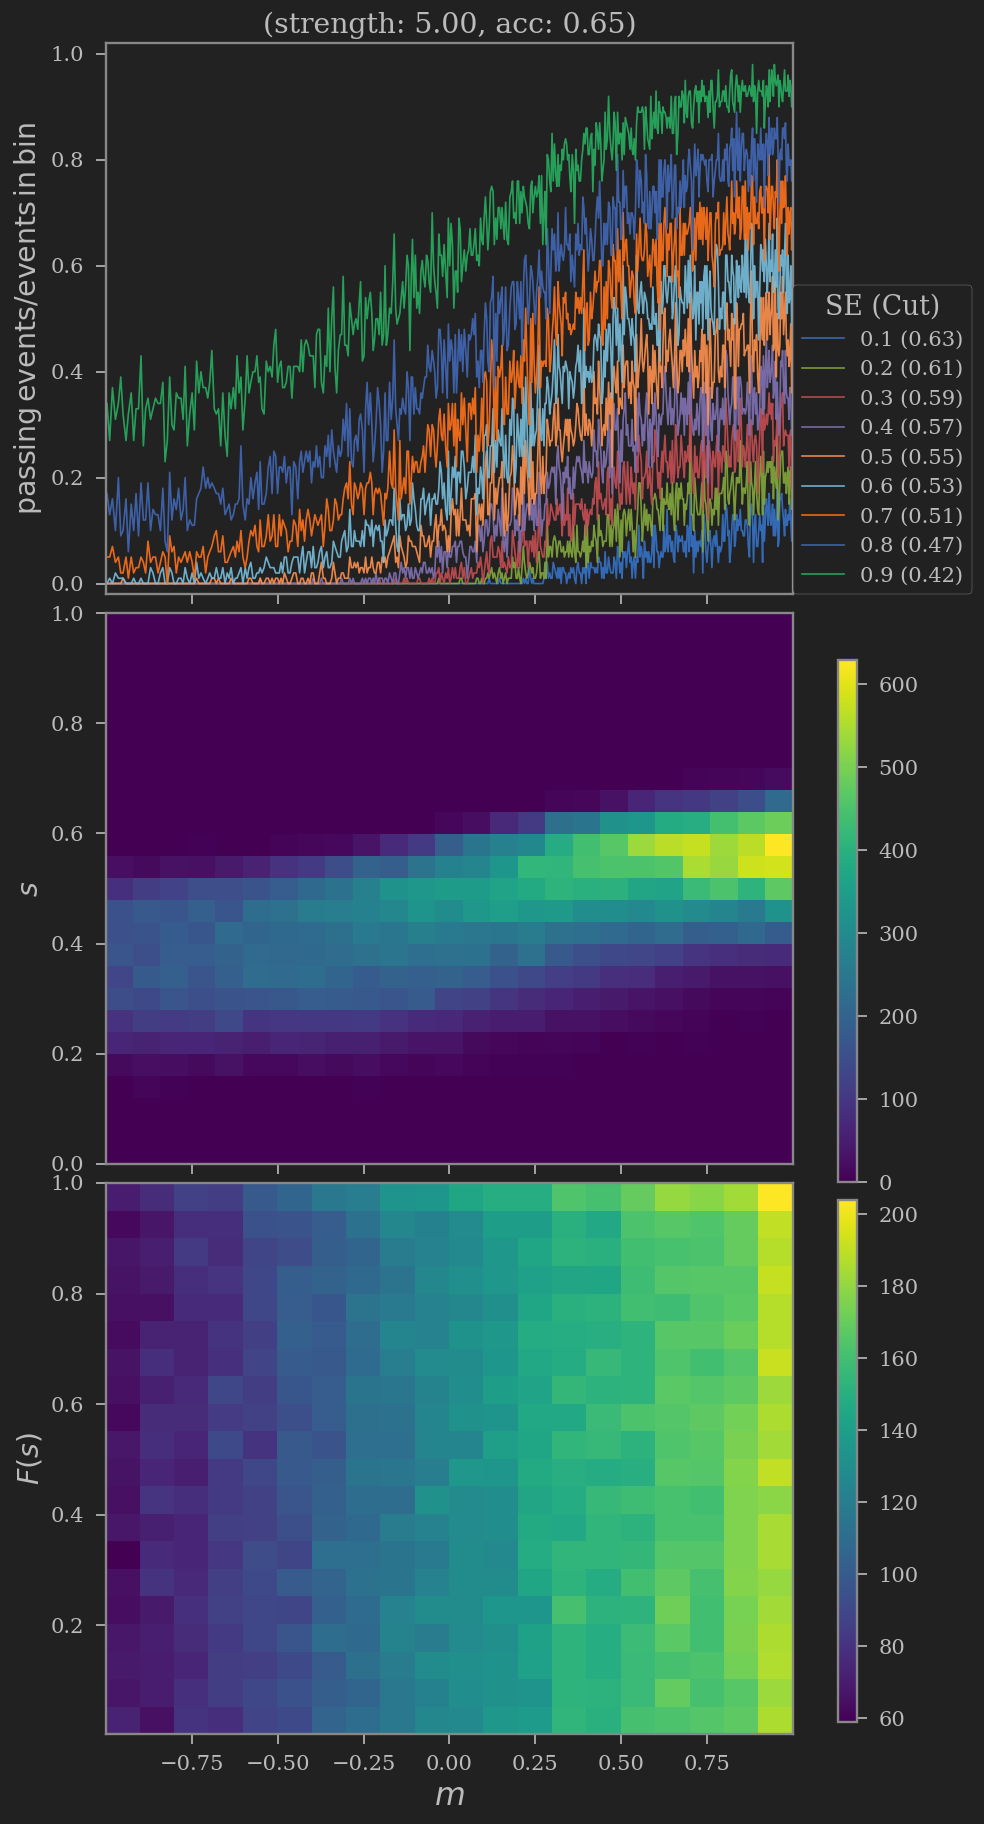

Epoch:0000/1700 || Train: loss:0.0225, acc:53% || Test: loss: 0.2476, acc:53%
Epoch:0100/1700 || Train: loss:0.0224, acc:55% || Test: loss: 0.2466, acc:55%
Epoch:0200/1700 || Train: loss:0.0224, acc:57% || Test: loss: 0.2457, acc:56%
Epoch:0300/1700 || Train: loss:0.0223, acc:58% || Test: loss: 0.2448, acc:58%
Epoch:0400/1700 || Train: loss:0.0222, acc:59% || Test: loss: 0.2439, acc:59%
Epoch:0500/1700 || Train: loss:0.0221, acc:60% || Test: loss: 0.2431, acc:60%
Epoch:0600/1700 || Train: loss:0.0220, acc:61% || Test: loss: 0.2422, acc:61%
Epoch:0700/1700 || Train: loss:0.0220, acc:62% || Test: loss: 0.2413, acc:62%
Epoch:0800/1700 || Train: loss:0.0219, acc:62% || Test: loss: 0.2405, acc:62%
Epoch:0900/1700 || Train: loss:0.0218, acc:63% || Test: loss: 0.2396, acc:63%
Epoch:1000/1700 || Train: loss:0.0217, acc:63% || Test: loss: 0.2388, acc:63%
Epoch:1100/1700 || Train: loss:0.0217, acc:63% || Test: loss: 0.2379, acc:63%
Epoch:1200/1700 || Train: loss:0.0216, acc:63% || Test: loss: 0.

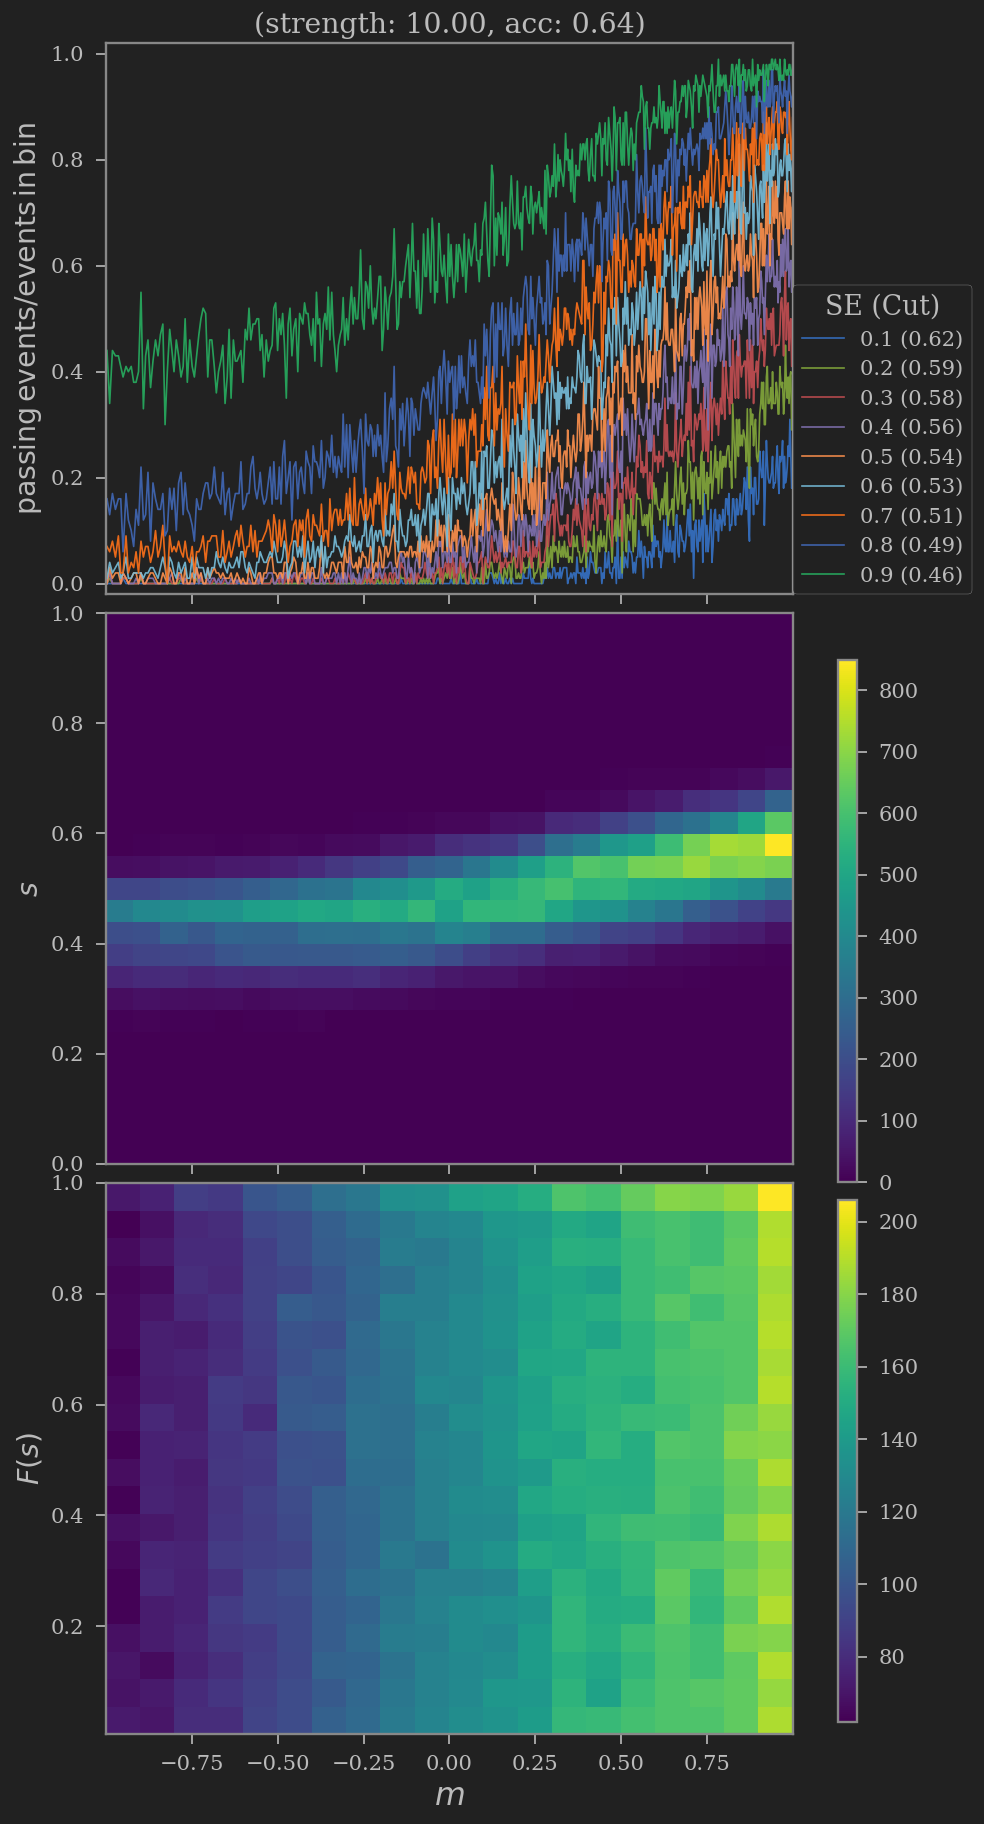

Epoch:0000/1700 || Train: loss:0.0157, acc:48% || Test: loss: 0.2513, acc:48%
Epoch:0100/1700 || Train: loss:0.0157, acc:49% || Test: loss: 0.2506, acc:50%
Epoch:0200/1700 || Train: loss:0.0157, acc:51% || Test: loss: 0.2500, acc:51%
Epoch:0300/1700 || Train: loss:0.0156, acc:52% || Test: loss: 0.2494, acc:52%
Epoch:0400/1700 || Train: loss:0.0156, acc:53% || Test: loss: 0.2489, acc:53%
Epoch:0500/1700 || Train: loss:0.0156, acc:54% || Test: loss: 0.2483, acc:54%
Epoch:0600/1700 || Train: loss:0.0155, acc:55% || Test: loss: 0.2478, acc:56%
Epoch:0700/1700 || Train: loss:0.0155, acc:56% || Test: loss: 0.2472, acc:57%
Epoch:0800/1700 || Train: loss:0.0155, acc:57% || Test: loss: 0.2467, acc:57%
Epoch:0900/1700 || Train: loss:0.0154, acc:58% || Test: loss: 0.2462, acc:58%
Epoch:1000/1700 || Train: loss:0.0154, acc:58% || Test: loss: 0.2456, acc:59%
Epoch:1100/1700 || Train: loss:0.0154, acc:58% || Test: loss: 0.2451, acc:59%
Epoch:1200/1700 || Train: loss:0.0153, acc:59% || Test: loss: 0.

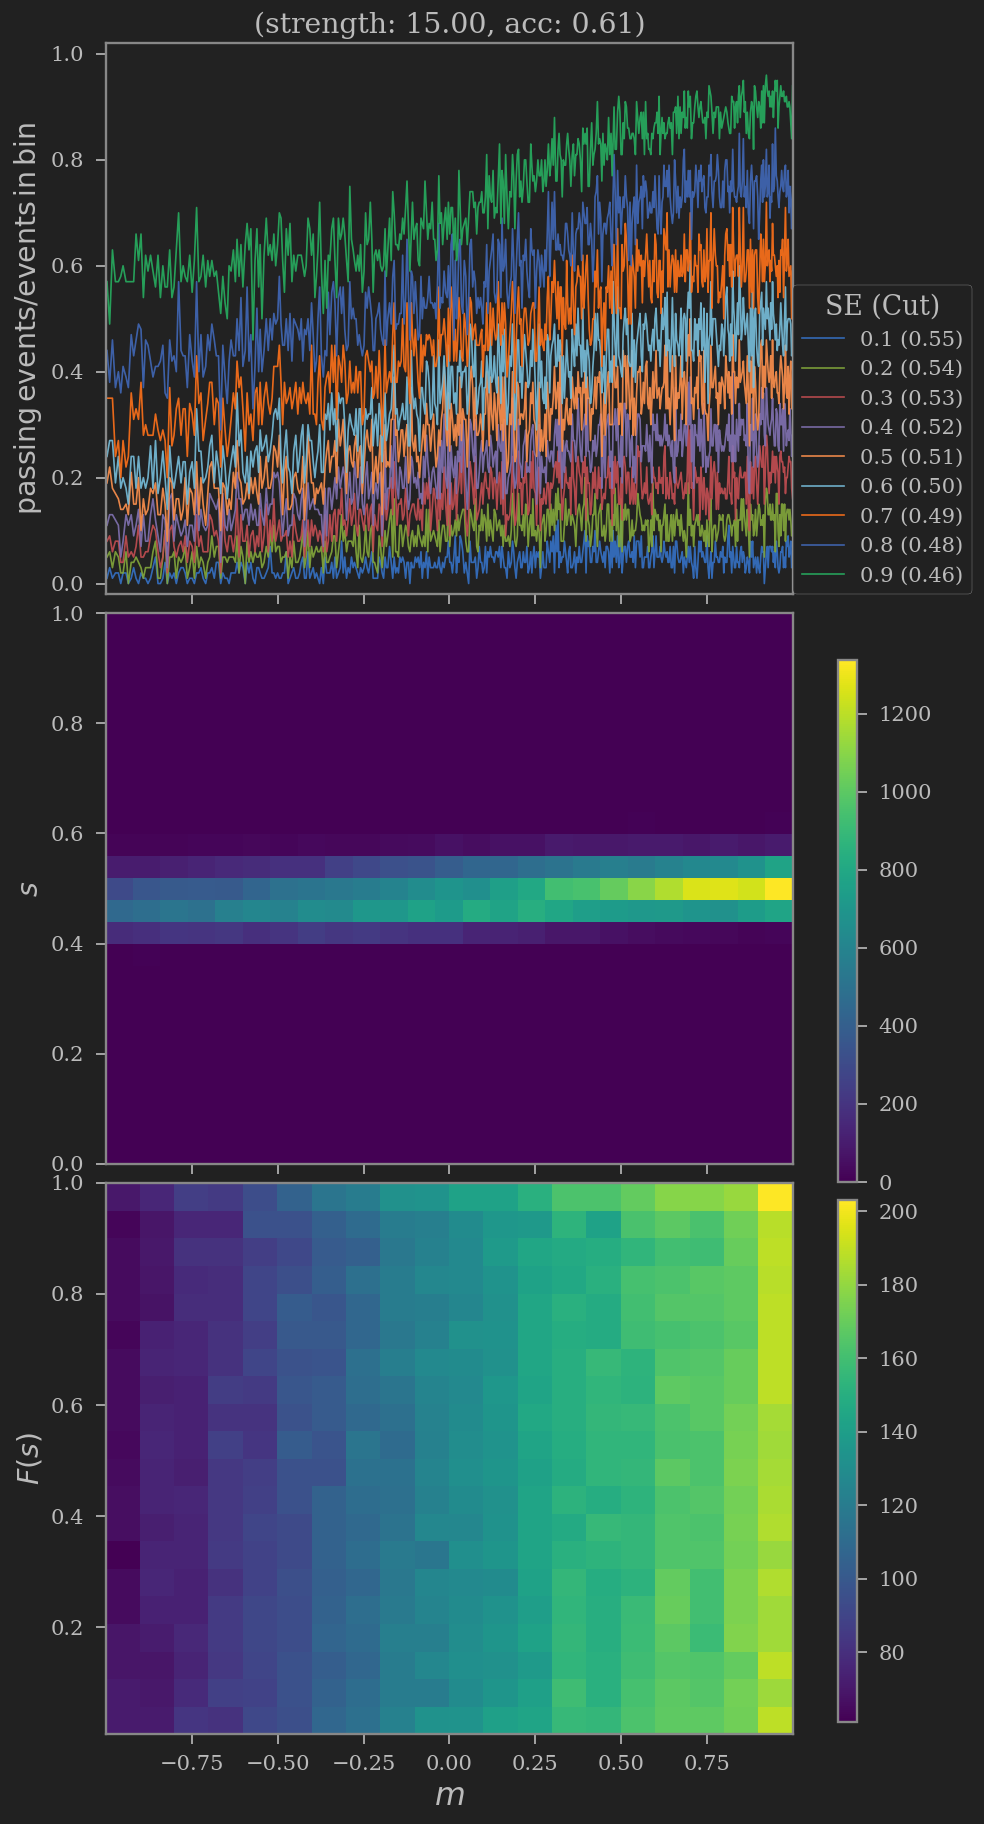

Epoch:0000/1700 || Train: loss:0.0118, acc:52% || Test: loss: 0.2465, acc:52%
Epoch:0100/1700 || Train: loss:0.0117, acc:55% || Test: loss: 0.2453, acc:56%
Epoch:0200/1700 || Train: loss:0.0117, acc:59% || Test: loss: 0.2443, acc:59%
Epoch:0300/1700 || Train: loss:0.0116, acc:61% || Test: loss: 0.2435, acc:61%
Epoch:0400/1700 || Train: loss:0.0116, acc:62% || Test: loss: 0.2427, acc:63%
Epoch:0500/1700 || Train: loss:0.0116, acc:63% || Test: loss: 0.2420, acc:64%
Epoch:0600/1700 || Train: loss:0.0115, acc:64% || Test: loss: 0.2414, acc:64%
Epoch:0700/1700 || Train: loss:0.0115, acc:64% || Test: loss: 0.2408, acc:64%
Epoch:0800/1700 || Train: loss:0.0115, acc:64% || Test: loss: 0.2403, acc:64%
Epoch:0900/1700 || Train: loss:0.0115, acc:64% || Test: loss: 0.2397, acc:64%
Epoch:1000/1700 || Train: loss:0.0114, acc:64% || Test: loss: 0.2392, acc:65%
Epoch:1100/1700 || Train: loss:0.0114, acc:64% || Test: loss: 0.2387, acc:65%
Epoch:1200/1700 || Train: loss:0.0114, acc:64% || Test: loss: 0.

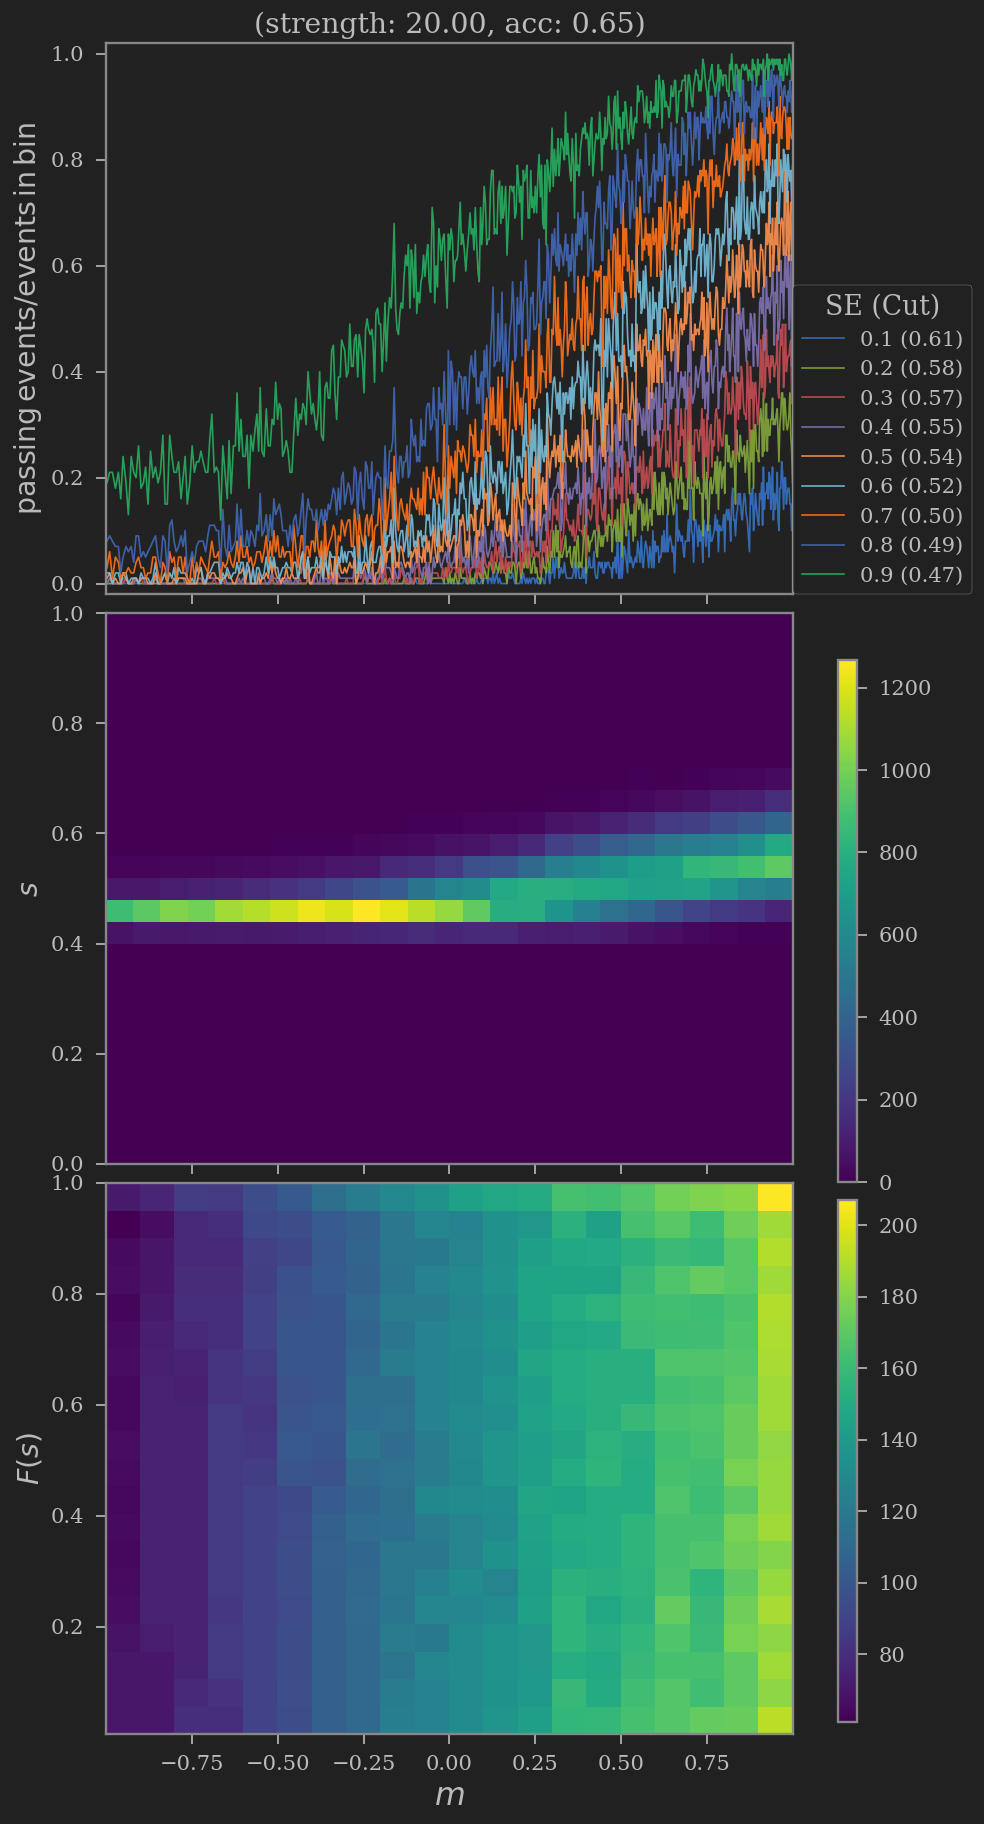

In [446]:
efficiencies = np.linspace(0.1,0.9,9)
for strength in [0,0.5,1,2,3,5,10,15,20]:
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics()
    model_legendre = Classifier()
    model_legendre.loss = LegendreLoss(frac=frac)
    model_legendre.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=1700,
                       metrics=[metrics_train_legendre,metrics_val_legendre], 
                       val_data=[x_val_tensor[:,1:],y_val_tensor])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = get_cuts(efficiencies)
    
    
    scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    ordered_score_mask = scores.argsort(axis=1)
    scores_ordered = scores#[np.arange(scores.shape[0])[:, None], ordered_score_mask]
    m_ordered_score = m_t.reshape(-1,100)#.reshape(-1,100)[np.arange(scores.shape[0])[:, None], ordered_score_mask]
    Fs = scores_ordered.cumsum(axis=1)/scores_ordered.sum(axis=1).reshape(-1,1)#scores_ordered.cumsum(axis=1)/scores_ordered.sum(axis=1).reshape(-1,1)



    fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores>cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

        #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
    #plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])#norm=LogNorm())
    cbaxes = fig.add_axes([0.86, 0.35, 0.02, 0.29]) 
    plt.colorbar(h,ax=ax2,cax = cbaxes)
    ax2.set_ylabel(r"$s$",fontsize=17)
    
    
    _,_,_,h = ax3.hist2d(m_ordered_score.flatten(),Fs.flatten(),bins=20, label="all")#norm=LogNorm())
    ax3.set_ylabel(r"$F(s)$",fontsize=17)
    cbaxes = fig.add_axes([0.86, 0.05, 0.02, 0.29]) 
    plt.colorbar(h,ax=ax3,cax = cbaxes)
    ax3.set_xlabel(r"$m$",fontsize=19)



    fig.tight_layout(pad=0)
    plt.show()

Epoch:0000/1700 || Train: loss:0.2511, acc:50% || Test: loss: 0.2510, acc:50%
Epoch:0100/1700 || Train: loss:0.2428, acc:64% || Test: loss: 0.2428, acc:64%
Epoch:0200/1700 || Train: loss:0.2328, acc:65% || Test: loss: 0.2329, acc:65%
Epoch:0300/1700 || Train: loss:0.2231, acc:66% || Test: loss: 0.2235, acc:66%
Epoch:0400/1700 || Train: loss:0.2167, acc:67% || Test: loss: 0.2174, acc:66%
Epoch:0500/1700 || Train: loss:0.2116, acc:68% || Test: loss: 0.2127, acc:67%
Epoch:0600/1700 || Train: loss:0.2064, acc:69% || Test: loss: 0.2077, acc:68%
Epoch:0700/1700 || Train: loss:0.2008, acc:70% || Test: loss: 0.2024, acc:70%
Epoch:0800/1700 || Train: loss:0.1949, acc:72% || Test: loss: 0.1969, acc:71%
Epoch:0900/1700 || Train: loss:0.1890, acc:73% || Test: loss: 0.1913, acc:73%
Epoch:1000/1700 || Train: loss:0.1834, acc:75% || Test: loss: 0.1859, acc:74%
Epoch:1100/1700 || Train: loss:0.1785, acc:76% || Test: loss: 0.1813, acc:76%
Epoch:1200/1700 || Train: loss:0.1749, acc:77% || Test: loss: 0.

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


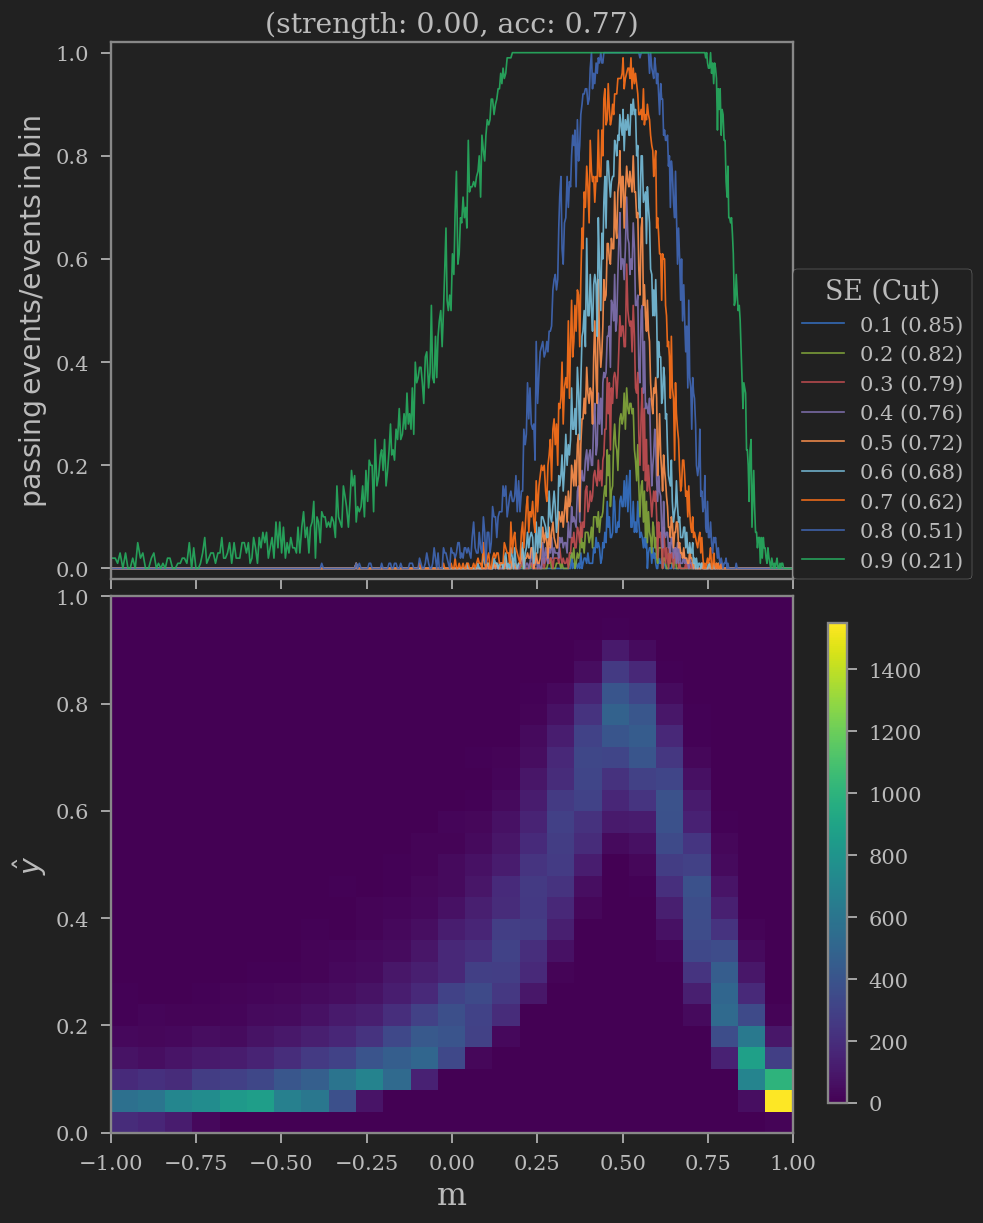

Epoch:0000/1700 || Train: loss:0.1652, acc:51% || Test: loss: 0.2479, acc:51%
Epoch:0100/1700 || Train: loss:0.1607, acc:66% || Test: loss: 0.2412, acc:65%
Epoch:0200/1700 || Train: loss:0.1562, acc:67% || Test: loss: 0.2346, acc:66%
Epoch:0300/1700 || Train: loss:0.1522, acc:67% || Test: loss: 0.2286, acc:66%
Epoch:0400/1700 || Train: loss:0.1491, acc:67% || Test: loss: 0.2240, acc:66%
Epoch:0500/1700 || Train: loss:0.1469, acc:67% || Test: loss: 0.2208, acc:66%
Epoch:0600/1700 || Train: loss:0.1453, acc:67% || Test: loss: 0.2183, acc:66%
Epoch:0700/1700 || Train: loss:0.1439, acc:67% || Test: loss: 0.2162, acc:67%
Epoch:0800/1700 || Train: loss:0.1427, acc:67% || Test: loss: 0.2142, acc:67%
Epoch:0900/1700 || Train: loss:0.1416, acc:68% || Test: loss: 0.2124, acc:67%
Epoch:1000/1700 || Train: loss:0.1405, acc:68% || Test: loss: 0.2105, acc:67%
Epoch:1100/1700 || Train: loss:0.1395, acc:69% || Test: loss: 0.2087, acc:68%
Epoch:1200/1700 || Train: loss:0.1385, acc:69% || Test: loss: 0.

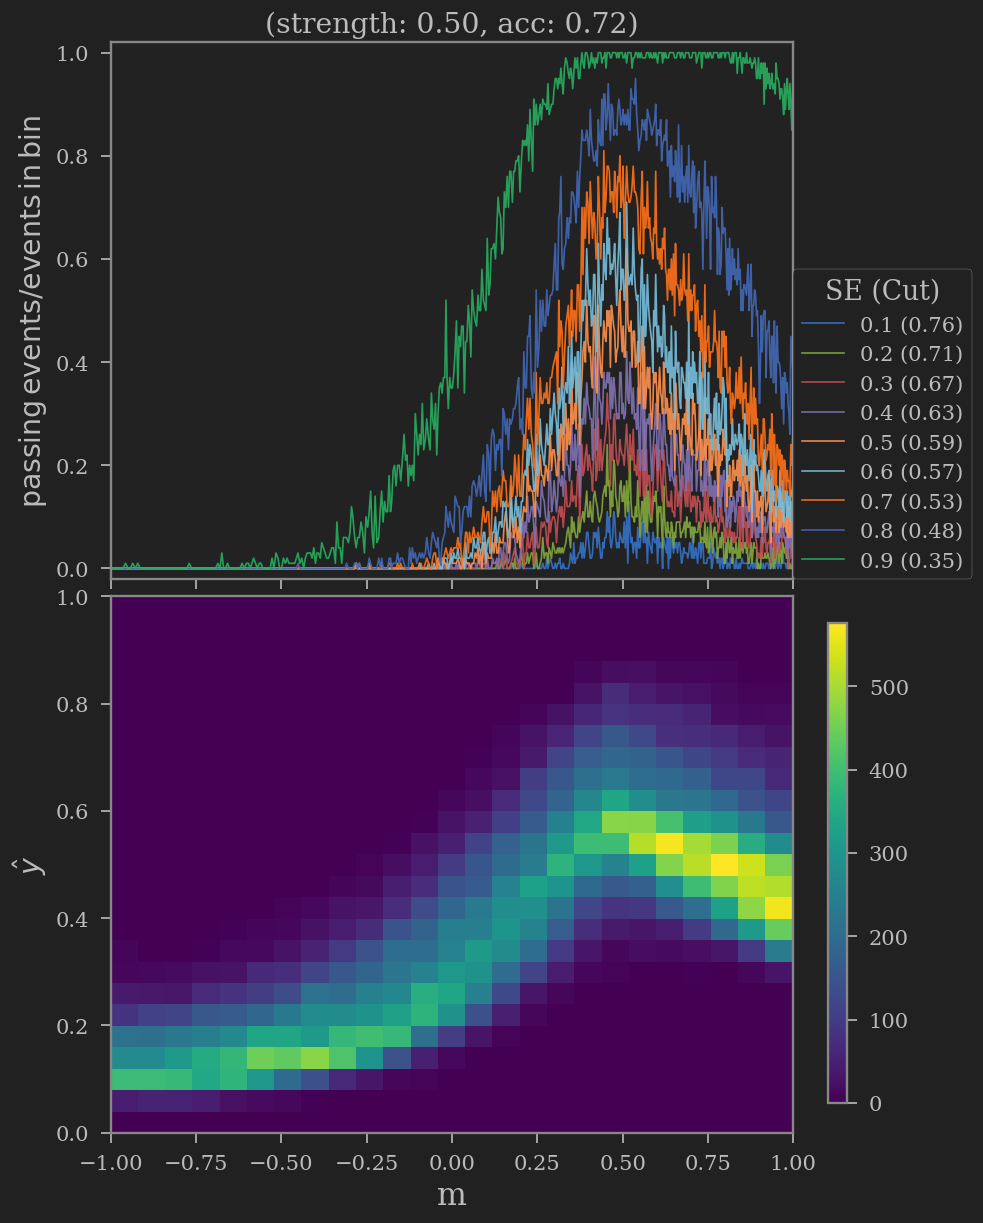

Epoch:0000/1700 || Train: loss:0.1256, acc:45% || Test: loss: 0.2511, acc:45%
Epoch:0100/1700 || Train: loss:0.1224, acc:58% || Test: loss: 0.2447, acc:59%
Epoch:0200/1700 || Train: loss:0.1201, acc:60% || Test: loss: 0.2401, acc:60%
Epoch:0300/1700 || Train: loss:0.1182, acc:62% || Test: loss: 0.2363, acc:61%
Epoch:0400/1700 || Train: loss:0.1167, acc:62% || Test: loss: 0.2332, acc:62%
Epoch:0500/1700 || Train: loss:0.1155, acc:63% || Test: loss: 0.2307, acc:63%
Epoch:0600/1700 || Train: loss:0.1145, acc:63% || Test: loss: 0.2286, acc:63%
Epoch:0700/1700 || Train: loss:0.1135, acc:64% || Test: loss: 0.2265, acc:64%
Epoch:0800/1700 || Train: loss:0.1125, acc:64% || Test: loss: 0.2245, acc:64%
Epoch:0900/1700 || Train: loss:0.1115, acc:65% || Test: loss: 0.2224, acc:65%
Epoch:1000/1700 || Train: loss:0.1105, acc:65% || Test: loss: 0.2201, acc:65%
Epoch:1100/1700 || Train: loss:0.1094, acc:66% || Test: loss: 0.2179, acc:66%
Epoch:1200/1700 || Train: loss:0.1084, acc:67% || Test: loss: 0.

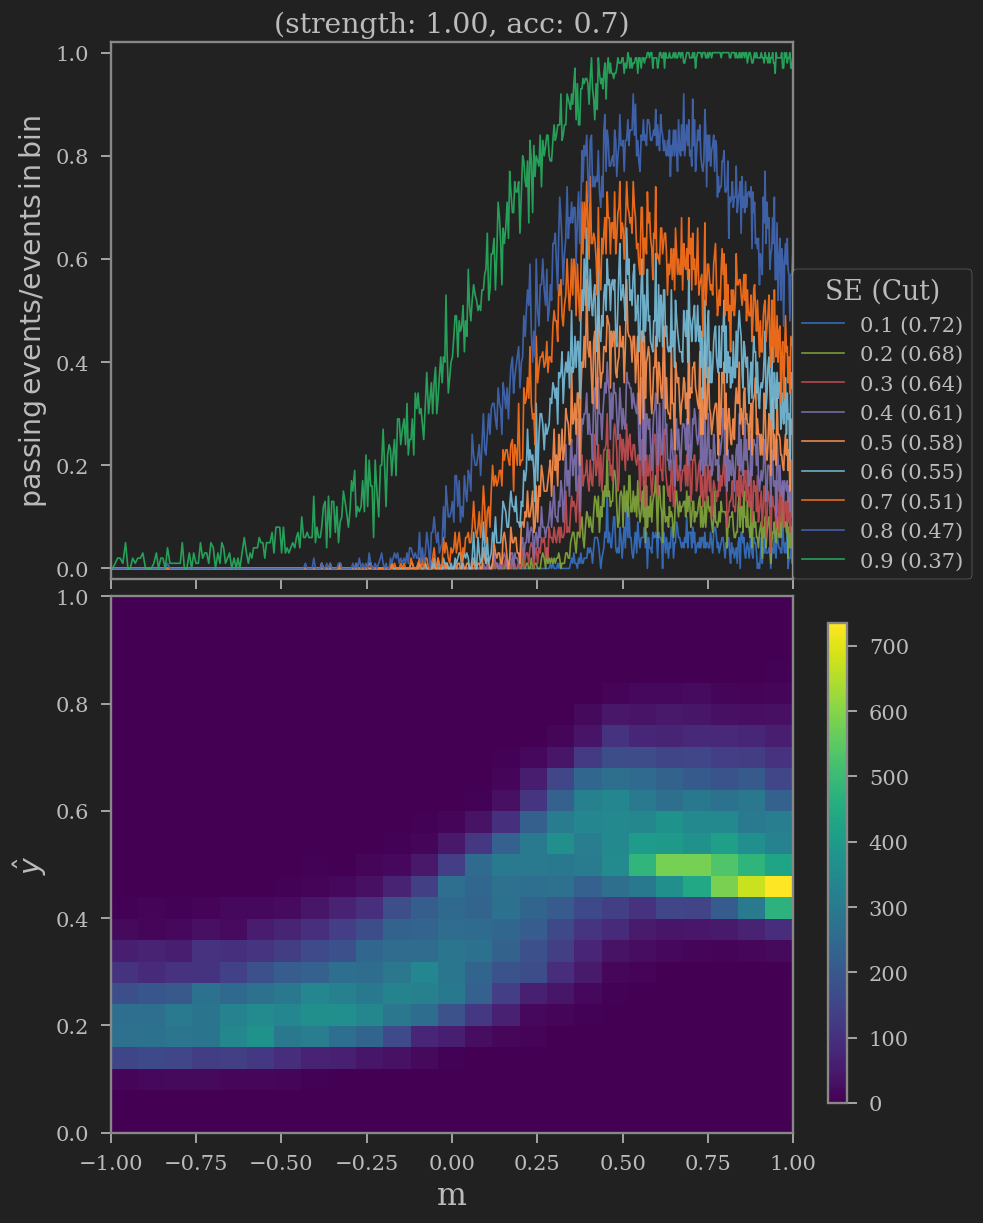

Epoch:0000/1700 || Train: loss:0.0821, acc:60% || Test: loss: 0.2462, acc:60%
Epoch:0100/1700 || Train: loss:0.0807, acc:62% || Test: loss: 0.2421, acc:62%
Epoch:0200/1700 || Train: loss:0.0795, acc:63% || Test: loss: 0.2384, acc:63%
Epoch:0300/1700 || Train: loss:0.0783, acc:64% || Test: loss: 0.2347, acc:64%
Epoch:0400/1700 || Train: loss:0.0772, acc:65% || Test: loss: 0.2311, acc:64%
Epoch:0500/1700 || Train: loss:0.0761, acc:65% || Test: loss: 0.2276, acc:65%
Epoch:0600/1700 || Train: loss:0.0752, acc:66% || Test: loss: 0.2246, acc:66%
Epoch:0700/1700 || Train: loss:0.0744, acc:66% || Test: loss: 0.2219, acc:66%
Epoch:0800/1700 || Train: loss:0.0739, acc:67% || Test: loss: 0.2198, acc:66%
Epoch:0900/1700 || Train: loss:0.0734, acc:67% || Test: loss: 0.2180, acc:67%
Epoch:1000/1700 || Train: loss:0.0731, acc:67% || Test: loss: 0.2166, acc:67%
Epoch:1100/1700 || Train: loss:0.0728, acc:68% || Test: loss: 0.2154, acc:67%
Epoch:1200/1700 || Train: loss:0.0726, acc:68% || Test: loss: 0.

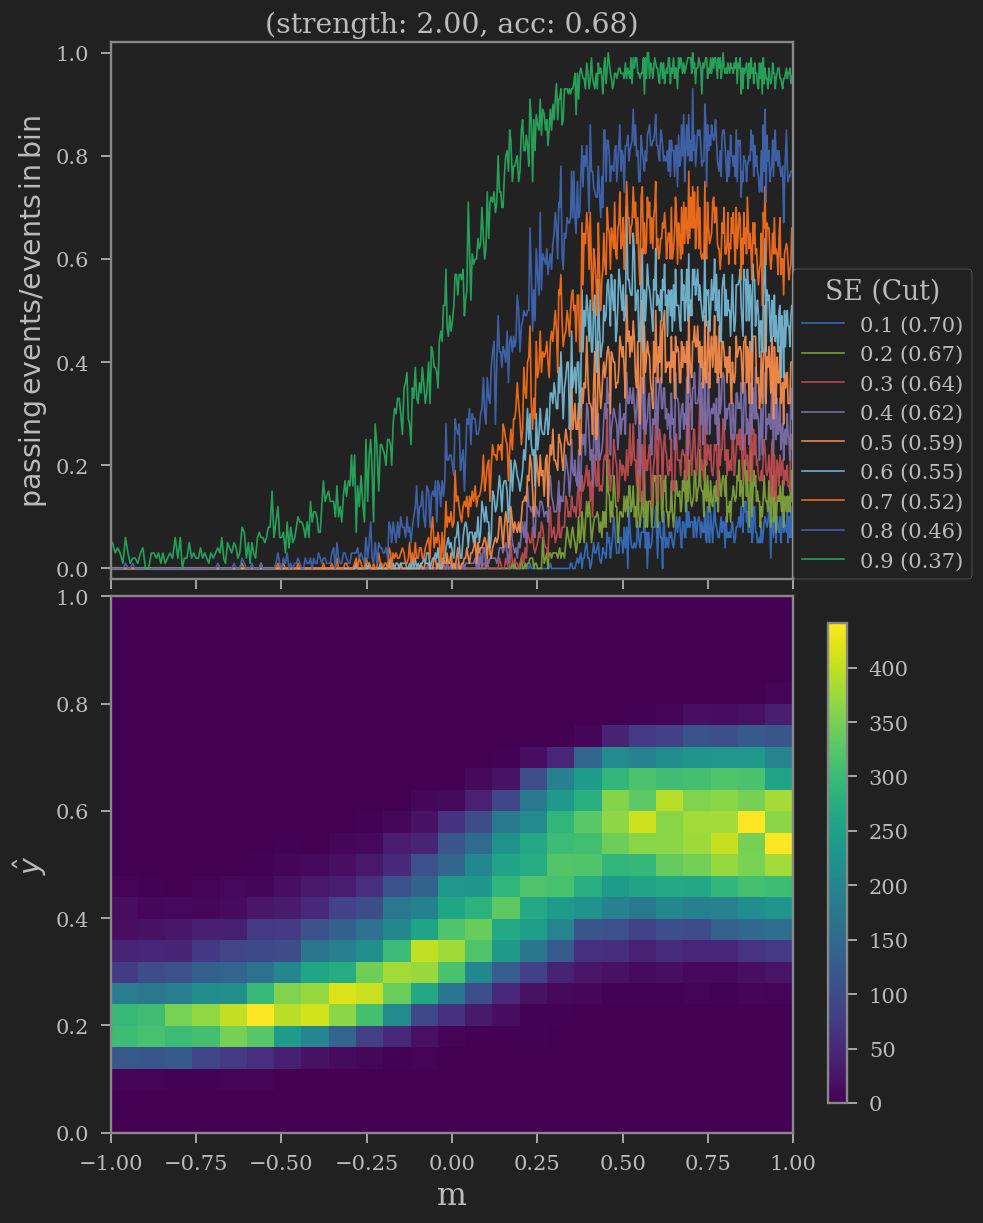

Epoch:0000/1700 || Train: loss:0.0636, acc:44% || Test: loss: 0.2542, acc:44%
Epoch:0100/1700 || Train: loss:0.0620, acc:53% || Test: loss: 0.2478, acc:53%
Epoch:0200/1700 || Train: loss:0.0613, acc:62% || Test: loss: 0.2448, acc:61%
Epoch:0300/1700 || Train: loss:0.0607, acc:64% || Test: loss: 0.2426, acc:63%
Epoch:0400/1700 || Train: loss:0.0603, acc:64% || Test: loss: 0.2407, acc:64%
Epoch:0500/1700 || Train: loss:0.0599, acc:64% || Test: loss: 0.2389, acc:64%
Epoch:0600/1700 || Train: loss:0.0595, acc:64% || Test: loss: 0.2374, acc:64%
Epoch:0700/1700 || Train: loss:0.0592, acc:64% || Test: loss: 0.2360, acc:64%
Epoch:0800/1700 || Train: loss:0.0589, acc:64% || Test: loss: 0.2347, acc:64%
Epoch:0900/1700 || Train: loss:0.0587, acc:64% || Test: loss: 0.2335, acc:64%
Epoch:1000/1700 || Train: loss:0.0584, acc:64% || Test: loss: 0.2324, acc:64%
Epoch:1100/1700 || Train: loss:0.0582, acc:64% || Test: loss: 0.2314, acc:64%
Epoch:1200/1700 || Train: loss:0.0580, acc:64% || Test: loss: 0.

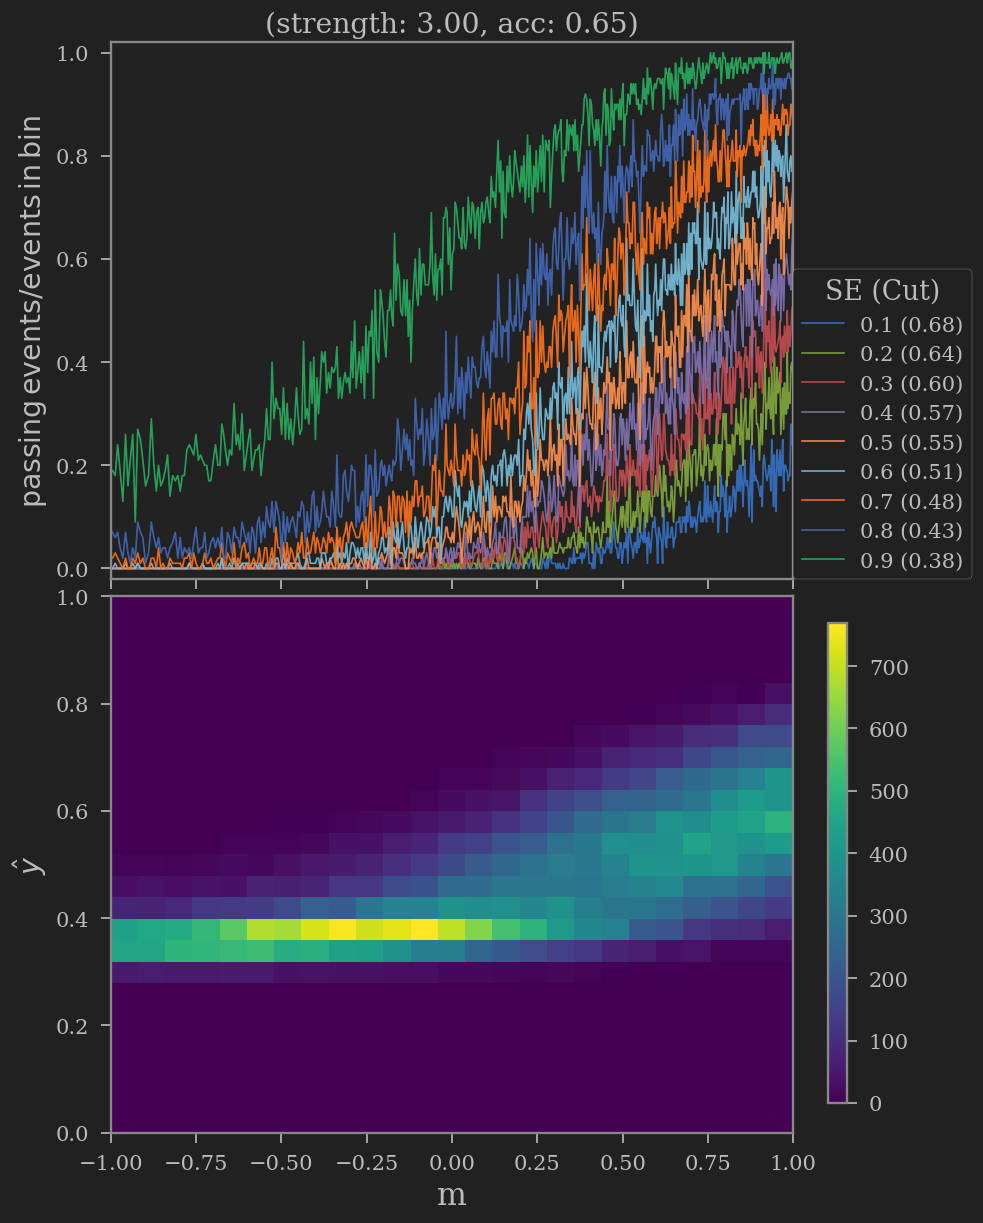

Epoch:0000/1700 || Train: loss:0.0504, acc:50% || Test: loss: 0.2519, acc:49%
Epoch:0100/1700 || Train: loss:0.0498, acc:51% || Test: loss: 0.2490, acc:50%
Epoch:0200/1700 || Train: loss:0.0493, acc:55% || Test: loss: 0.2465, acc:55%
Epoch:0300/1700 || Train: loss:0.0489, acc:63% || Test: loss: 0.2442, acc:63%
Epoch:0400/1700 || Train: loss:0.0484, acc:66% || Test: loss: 0.2420, acc:66%
Epoch:0500/1700 || Train: loss:0.0480, acc:67% || Test: loss: 0.2398, acc:67%
Epoch:0600/1700 || Train: loss:0.0476, acc:67% || Test: loss: 0.2376, acc:67%
Epoch:0700/1700 || Train: loss:0.0472, acc:67% || Test: loss: 0.2354, acc:67%
Epoch:0800/1700 || Train: loss:0.0468, acc:67% || Test: loss: 0.2332, acc:67%
Epoch:0900/1700 || Train: loss:0.0464, acc:67% || Test: loss: 0.2311, acc:67%
Epoch:1000/1700 || Train: loss:0.0461, acc:67% || Test: loss: 0.2291, acc:67%
Epoch:1100/1700 || Train: loss:0.0458, acc:67% || Test: loss: 0.2273, acc:67%
Epoch:1200/1700 || Train: loss:0.0455, acc:67% || Test: loss: 0.

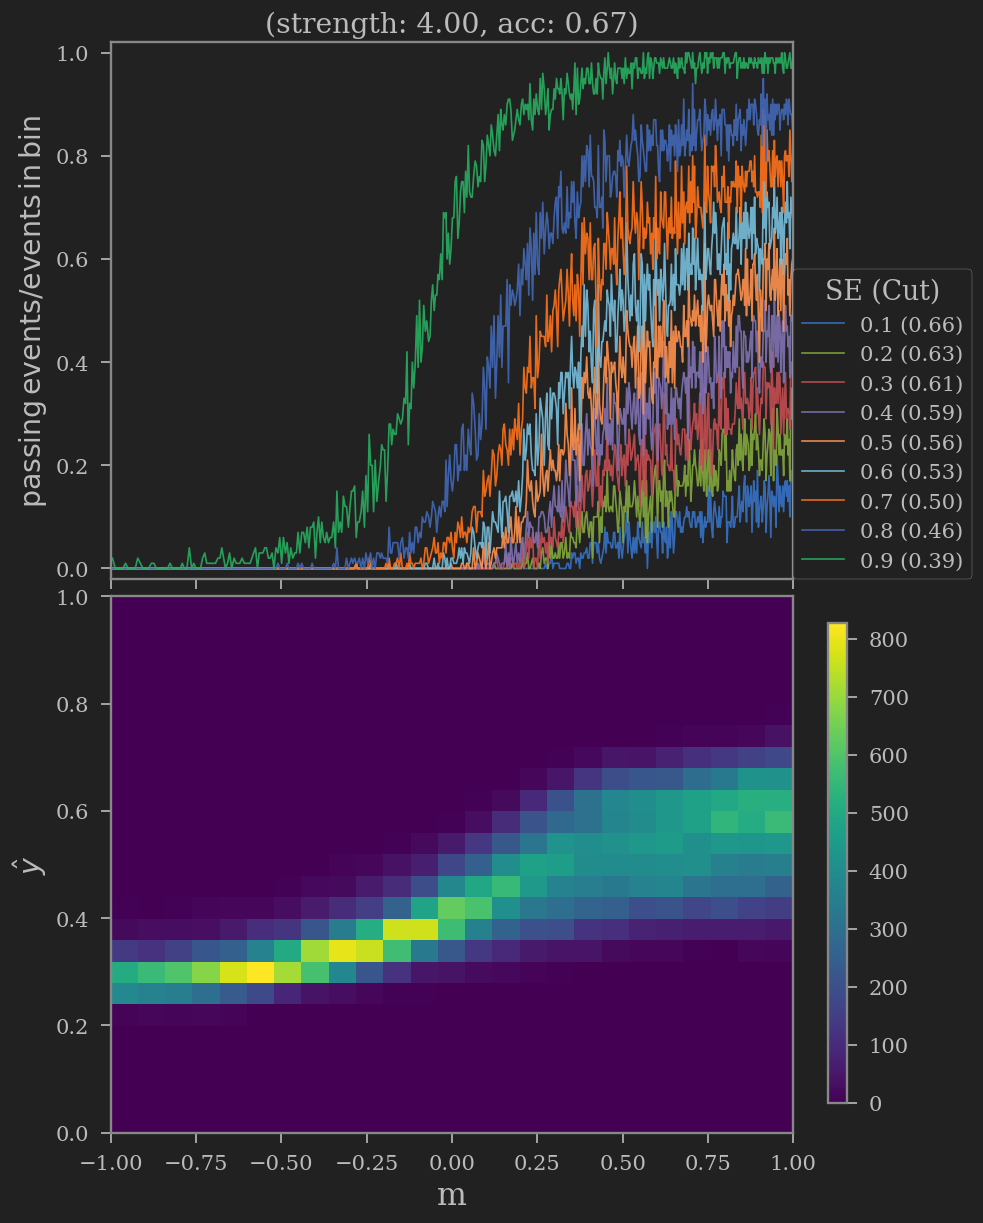

Epoch:0000/1700 || Train: loss:0.0424, acc:50% || Test: loss: 0.2540, acc:50%
Epoch:0100/1700 || Train: loss:0.0419, acc:49% || Test: loss: 0.2510, acc:49%
Epoch:0200/1700 || Train: loss:0.0416, acc:48% || Test: loss: 0.2492, acc:49%
Epoch:0300/1700 || Train: loss:0.0414, acc:54% || Test: loss: 0.2479, acc:54%
Epoch:0400/1700 || Train: loss:0.0412, acc:56% || Test: loss: 0.2468, acc:57%
Epoch:0500/1700 || Train: loss:0.0410, acc:57% || Test: loss: 0.2458, acc:58%
Epoch:0600/1700 || Train: loss:0.0409, acc:58% || Test: loss: 0.2449, acc:58%
Epoch:0700/1700 || Train: loss:0.0407, acc:59% || Test: loss: 0.2439, acc:59%
Epoch:0800/1700 || Train: loss:0.0406, acc:59% || Test: loss: 0.2429, acc:59%
Epoch:0900/1700 || Train: loss:0.0404, acc:59% || Test: loss: 0.2419, acc:60%
Epoch:1000/1700 || Train: loss:0.0403, acc:60% || Test: loss: 0.2409, acc:60%
Epoch:1100/1700 || Train: loss:0.0401, acc:60% || Test: loss: 0.2398, acc:60%
Epoch:1200/1700 || Train: loss:0.0399, acc:61% || Test: loss: 0.

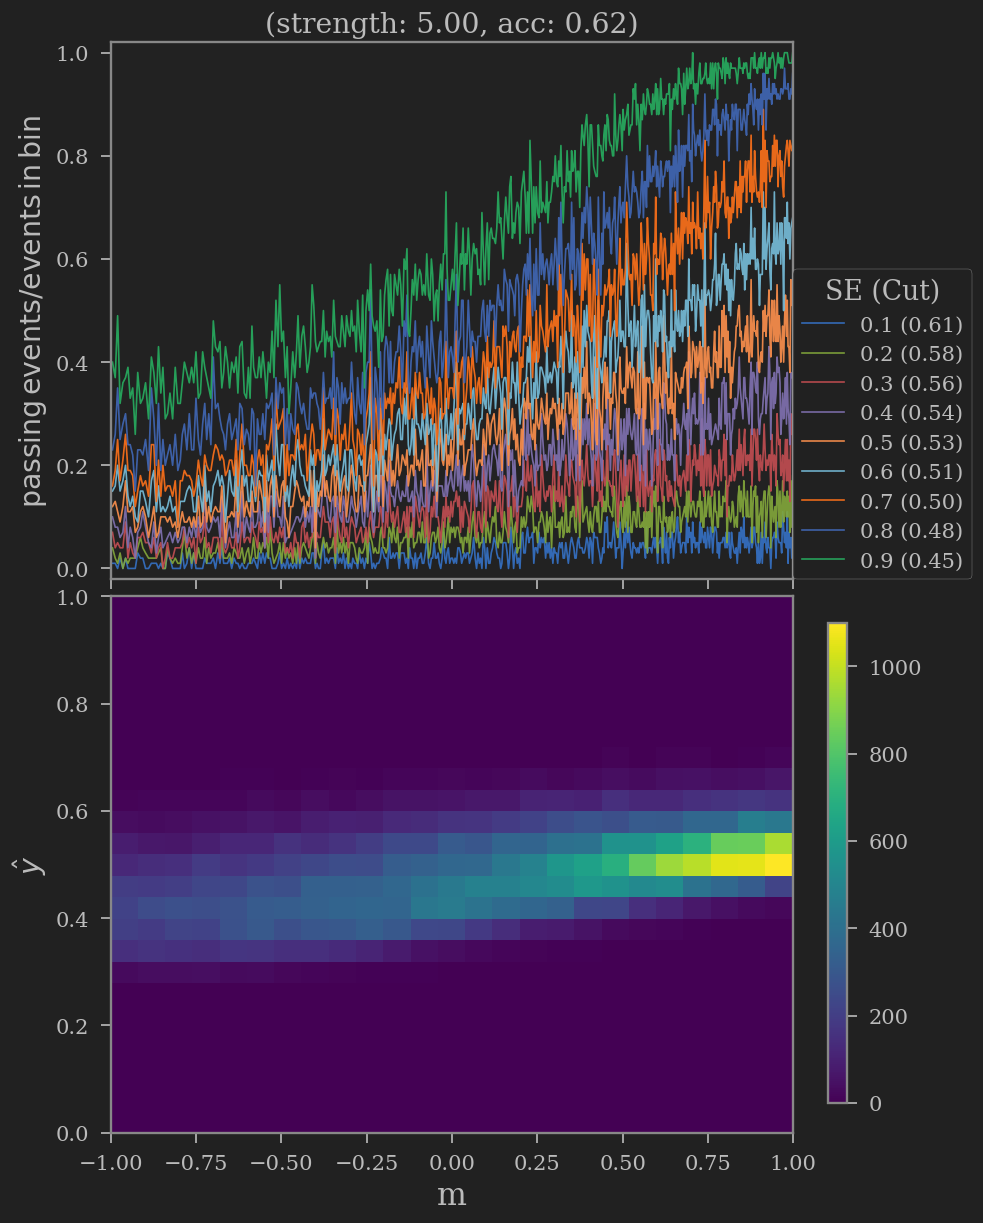

Epoch:0000/1700 || Train: loss:0.0229, acc:43% || Test: loss: 0.2510, acc:43%
Epoch:0100/1700 || Train: loss:0.0227, acc:54% || Test: loss: 0.2495, acc:54%
Epoch:0200/1700 || Train: loss:0.0226, acc:56% || Test: loss: 0.2482, acc:56%
Epoch:0300/1700 || Train: loss:0.0225, acc:58% || Test: loss: 0.2470, acc:58%
Epoch:0400/1700 || Train: loss:0.0224, acc:59% || Test: loss: 0.2460, acc:59%
Epoch:0500/1700 || Train: loss:0.0223, acc:60% || Test: loss: 0.2450, acc:60%
Epoch:0600/1700 || Train: loss:0.0223, acc:61% || Test: loss: 0.2441, acc:61%
Epoch:0700/1700 || Train: loss:0.0222, acc:61% || Test: loss: 0.2431, acc:61%
Epoch:0800/1700 || Train: loss:0.0221, acc:62% || Test: loss: 0.2423, acc:62%
Epoch:0900/1700 || Train: loss:0.0220, acc:62% || Test: loss: 0.2414, acc:62%
Epoch:1000/1700 || Train: loss:0.0220, acc:62% || Test: loss: 0.2406, acc:62%
Epoch:1100/1700 || Train: loss:0.0219, acc:62% || Test: loss: 0.2398, acc:62%
Epoch:1200/1700 || Train: loss:0.0219, acc:63% || Test: loss: 0.

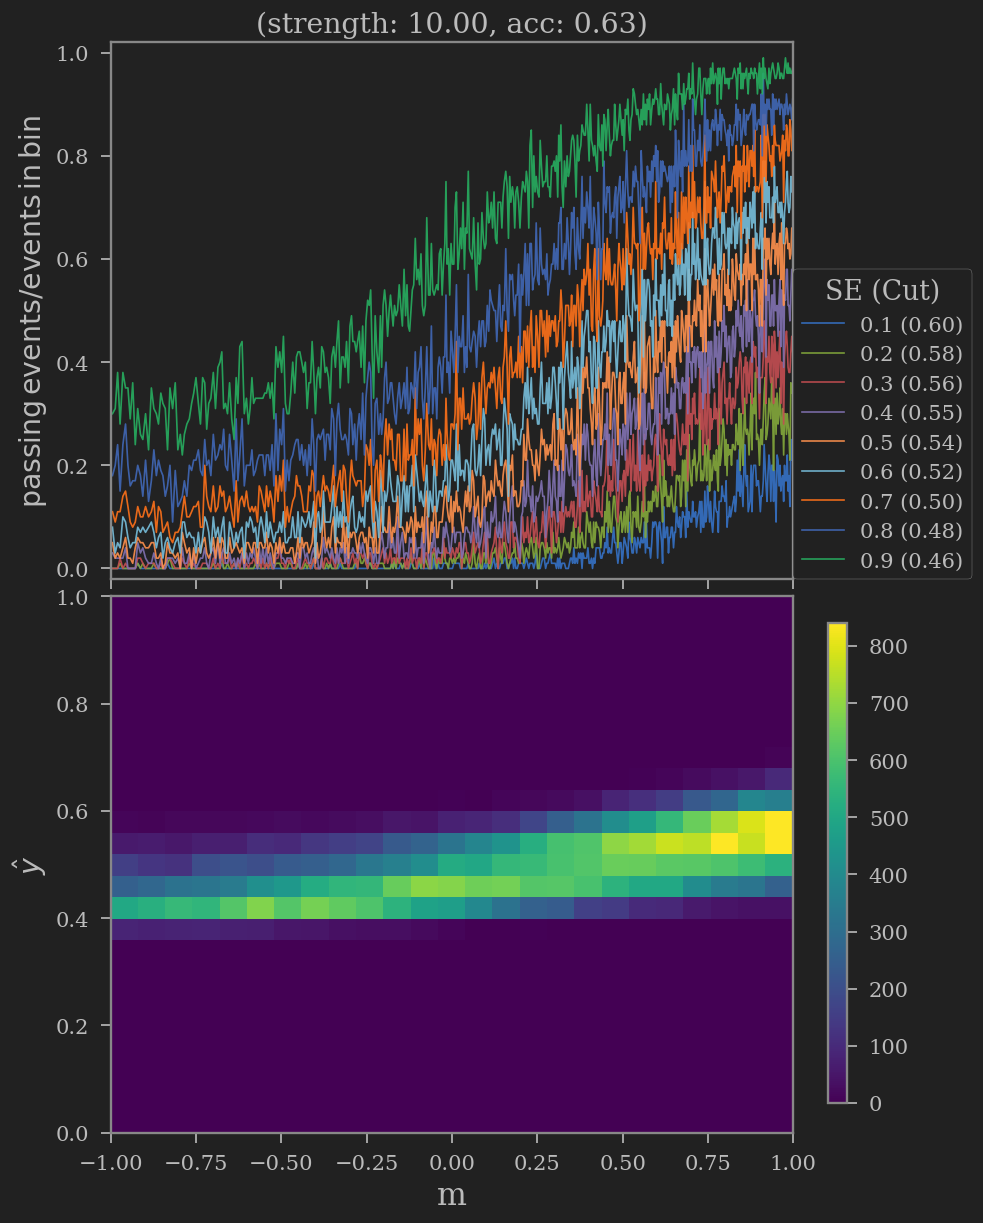

Epoch:0000/1700 || Train: loss:0.0119, acc:52% || Test: loss: 0.2483, acc:52%
Epoch:0100/1700 || Train: loss:0.0119, acc:53% || Test: loss: 0.2480, acc:53%
Epoch:0200/1700 || Train: loss:0.0119, acc:53% || Test: loss: 0.2478, acc:53%
Epoch:0300/1700 || Train: loss:0.0118, acc:54% || Test: loss: 0.2476, acc:54%
Epoch:0400/1700 || Train: loss:0.0118, acc:54% || Test: loss: 0.2474, acc:54%
Epoch:0500/1700 || Train: loss:0.0118, acc:55% || Test: loss: 0.2472, acc:55%
Epoch:0600/1700 || Train: loss:0.0118, acc:55% || Test: loss: 0.2469, acc:55%
Epoch:0700/1700 || Train: loss:0.0118, acc:56% || Test: loss: 0.2467, acc:56%
Epoch:0800/1700 || Train: loss:0.0118, acc:57% || Test: loss: 0.2465, acc:56%
Epoch:0900/1700 || Train: loss:0.0118, acc:57% || Test: loss: 0.2463, acc:57%
Epoch:1000/1700 || Train: loss:0.0118, acc:57% || Test: loss: 0.2461, acc:57%
Epoch:1100/1700 || Train: loss:0.0118, acc:58% || Test: loss: 0.2459, acc:57%
Epoch:1200/1700 || Train: loss:0.0118, acc:58% || Test: loss: 0.

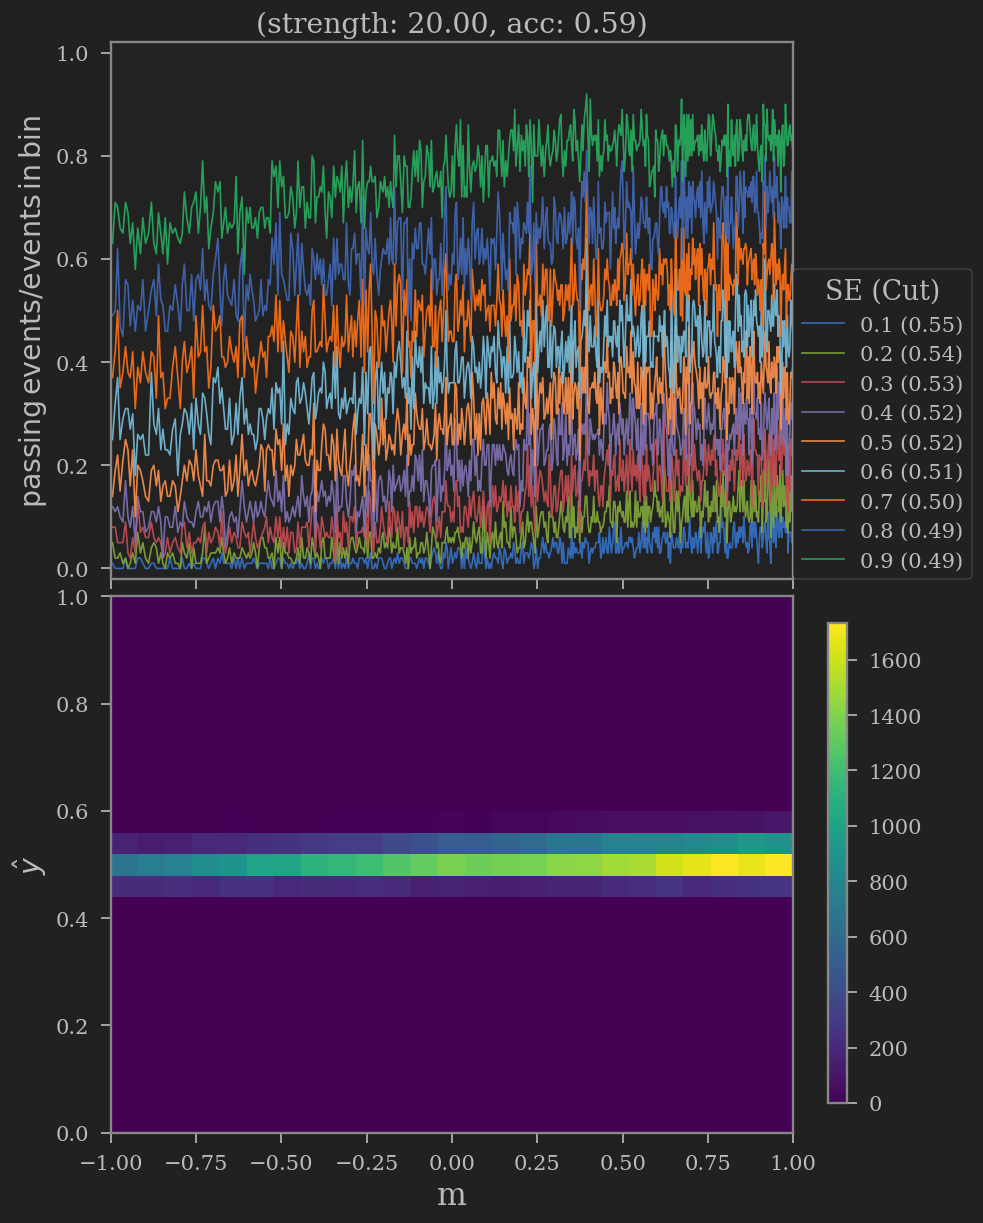

Epoch:0000/1700 || Train: loss:0.0062, acc:50% || Test: loss: 0.2509, acc:50%
Epoch:0100/1700 || Train: loss:0.0061, acc:50% || Test: loss: 0.2505, acc:50%
Epoch:0200/1700 || Train: loss:0.0061, acc:50% || Test: loss: 0.2502, acc:50%
Epoch:0300/1700 || Train: loss:0.0061, acc:50% || Test: loss: 0.2499, acc:50%
Epoch:0400/1700 || Train: loss:0.0061, acc:50% || Test: loss: 0.2496, acc:50%
Epoch:0500/1700 || Train: loss:0.0061, acc:50% || Test: loss: 0.2493, acc:50%
Epoch:0600/1700 || Train: loss:0.0061, acc:50% || Test: loss: 0.2490, acc:50%
Epoch:0700/1700 || Train: loss:0.0061, acc:51% || Test: loss: 0.2487, acc:51%
Epoch:0800/1700 || Train: loss:0.0061, acc:51% || Test: loss: 0.2485, acc:51%
Epoch:0900/1700 || Train: loss:0.0061, acc:51% || Test: loss: 0.2482, acc:51%
Epoch:1000/1700 || Train: loss:0.0061, acc:52% || Test: loss: 0.2479, acc:52%
Epoch:1100/1700 || Train: loss:0.0061, acc:52% || Test: loss: 0.2477, acc:52%
Epoch:1200/1700 || Train: loss:0.0061, acc:53% || Test: loss: 0.

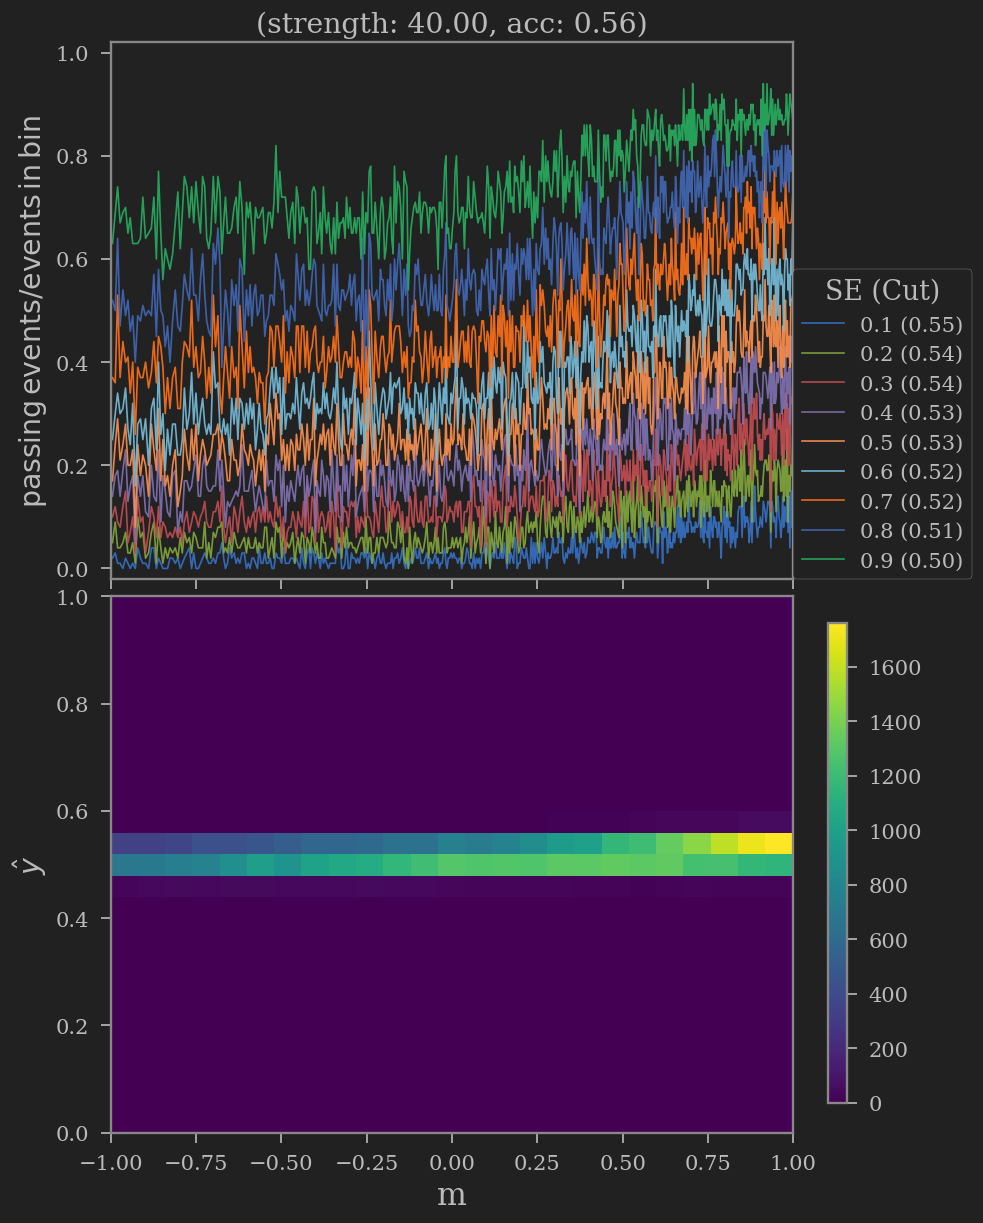

Epoch:0000/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2517, acc:50%
Epoch:0100/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2516, acc:50%
Epoch:0200/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2514, acc:50%
Epoch:0300/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2513, acc:50%
Epoch:0400/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2512, acc:50%
Epoch:0500/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2511, acc:50%
Epoch:0600/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2509, acc:50%
Epoch:0700/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2508, acc:50%
Epoch:0800/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2507, acc:50%
Epoch:0900/1700 || Train: loss:0.0031, acc:50% || Test: loss: 0.2506, acc:50%
Epoch:1000/1700 || Train: loss:0.0031, acc:51% || Test: loss: 0.2505, acc:50%
Epoch:1100/1700 || Train: loss:0.0031, acc:51% || Test: loss: 0.2504, acc:50%
Epoch:1200/1700 || Train: loss:0.0031, acc:51% || Test: loss: 0.

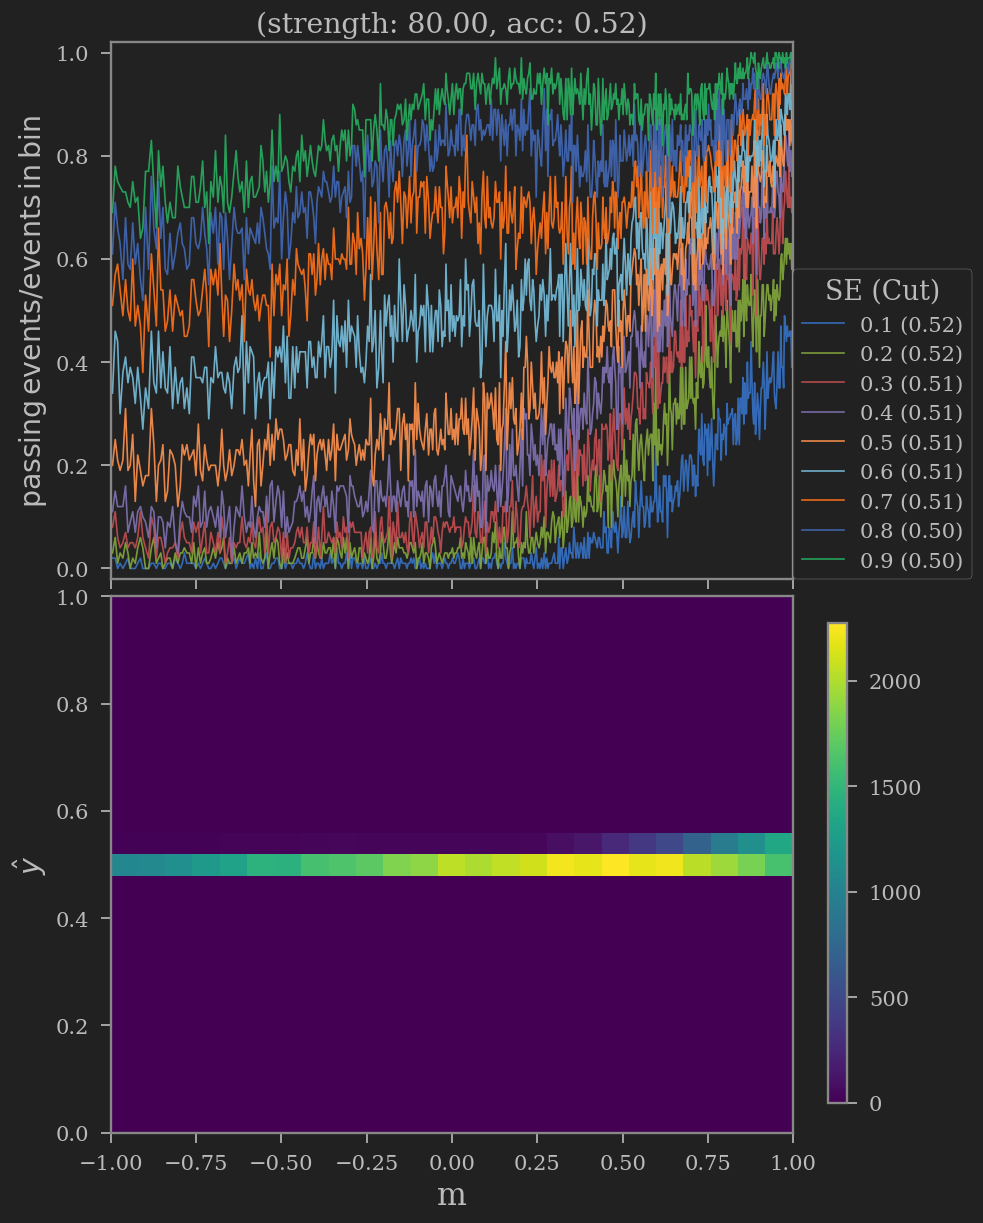

Epoch:0000/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2501, acc:50%
Epoch:0100/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2499, acc:50%
Epoch:0200/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2497, acc:50%
Epoch:0300/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2496, acc:50%
Epoch:0400/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2494, acc:50%
Epoch:0500/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2493, acc:50%
Epoch:0600/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2491, acc:50%
Epoch:0700/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2490, acc:50%
Epoch:0800/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2489, acc:50%
Epoch:0900/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2488, acc:50%
Epoch:1000/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2486, acc:50%
Epoch:1100/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.2485, acc:50%
Epoch:1200/1700 || Train: loss:0.0025, acc:50% || Test: loss: 0.

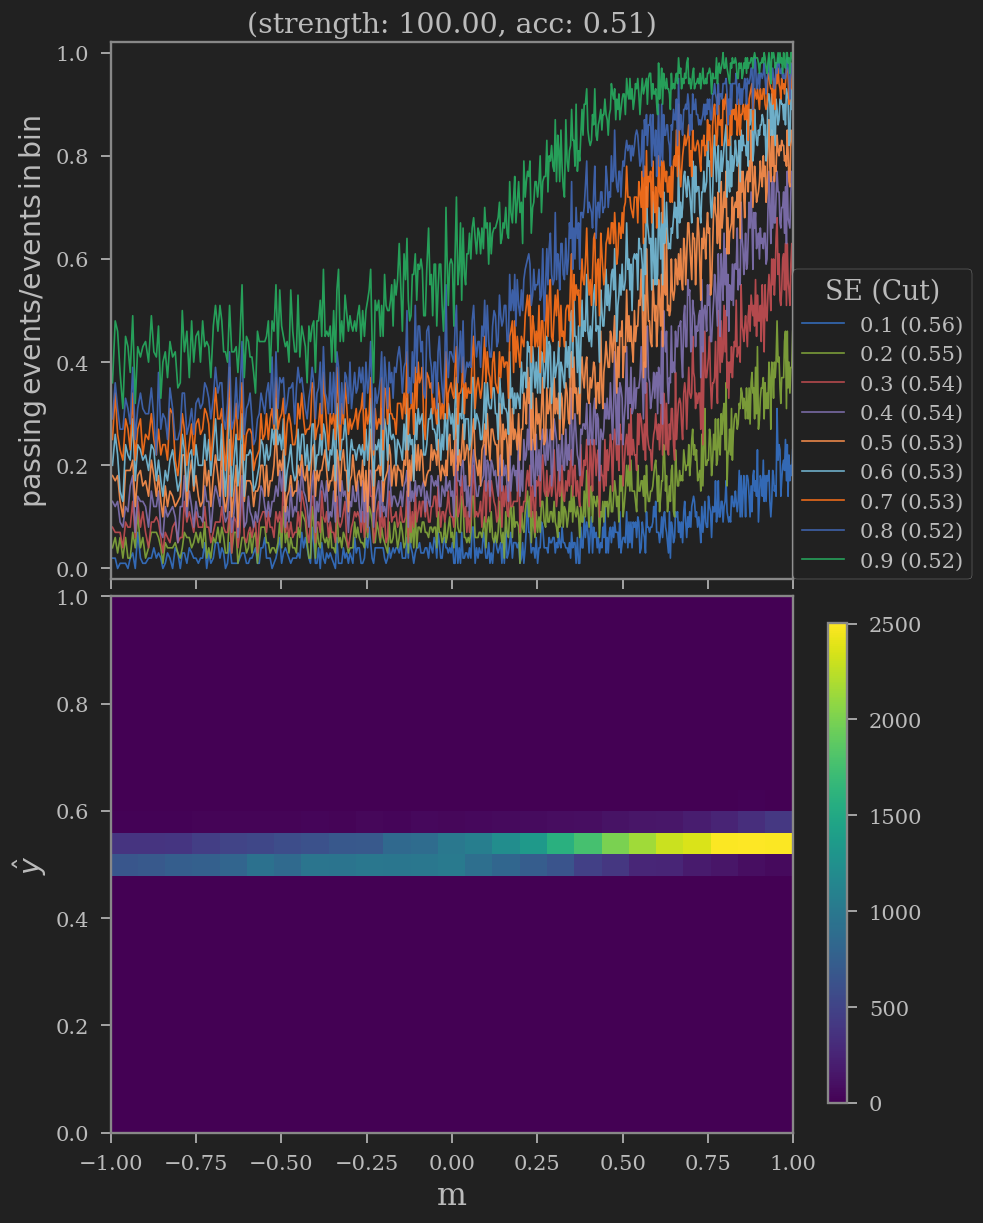

In [365]:
efficiencies = np.linspace(0.1,0.9,9)
for strength in [0,0.5,1,2,3,4,5,10,20,40,80,100]:
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics()
    model_legendre = Classifier()
    model_legendre.loss = LegendreLoss(frac=frac)
    model_legendre.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=1700,
                       metrics=[metrics_train_legendre,metrics_val_legendre], 
                       val_data=[x_val_tensor[:,1:],y_val_tensor])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = get_cuts(efficiencies)
    
    
    scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    


    fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores>cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

        #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
    #plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])#norm=LogNorm())
    cbaxes = fig.add_axes([0.85, 0.09, 0.02, 0.4]) 
    plt.colorbar(h,ax=ax2,cax = cbaxes)
    ax2.set_ylabel(r"$\hat{y}$",fontsize=17)
    ax2.set_xlabel("m",fontsize=19)
    fig.tight_layout(pad=0)
    plt.show()

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


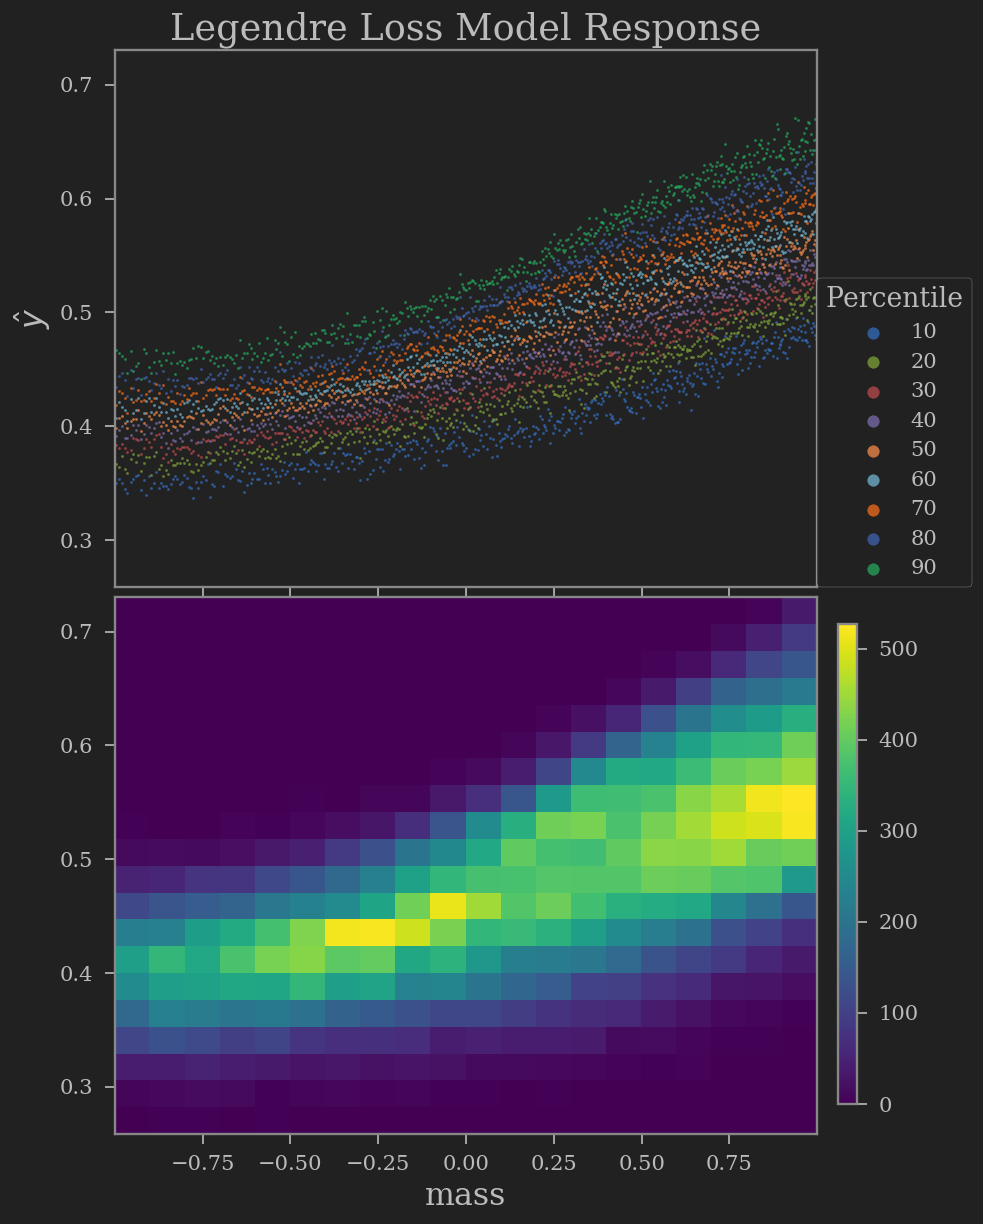

In [253]:
scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score = scores.argsort(axis=1)
scores = scores[np.arange(scores.shape[0])[:, None], ordered_score]


fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True,sharey=True)
for j,i in enumerate(range(10,scores.shape[1],10)):
    c = f"C{j}" if j!= 6 else f"C11"
    ax1.scatter(m,scores[:,i],label=f"{int(i*100/scores.shape[1])}",alpha=0.7,s=2,c=c)

    #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
ax1.set_ylabel(r"$\hat{y}$",fontsize=19)
ax1.set_title("Legendre Loss Model Response",fontsize=22)
ax1.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)

_,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=20, label="all")#norm=LogNorm())
cbaxes = fig.add_axes([0.86, 0.09, 0.02, 0.4]) 
plt.colorbar(h,ax=ax2,cax = cbaxes)
ax2.set_xlabel("mass",fontsize=19)
#plt.ylim([0,0.7])
fig.tight_layout(pad=0)
plt.show()

In [ ]:
metrics_train_jiang = Metrics()
metrics_val_jiang = Metrics()
model_jiang = Classifier()
model_jiang.loss = JiangLoss(eta=1e-3)
model_jiang.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=1400, delay_loss=1200,
                metrics=[metrics_train_jiang,metrics_val_jiang], 
                val_data=[x_val_tensor[:,1:],y_val_tensor])

Epoch:0000/1400 || Train: loss:0.2488, acc:50% || Test: loss: 0.2486, acc:50%
Epoch:0100/1400 || Train: loss:0.2417, acc:60% || Test: loss: 0.2416, acc:60%
Epoch:0200/1400 || Train: loss:0.2356, acc:61% || Test: loss: 0.2354, acc:61%
Epoch:0300/1400 || Train: loss:0.2307, acc:62% || Test: loss: 0.2304, acc:62%
Epoch:0400/1400 || Train: loss:0.2268, acc:63% || Test: loss: 0.2264, acc:63%
Epoch:0500/1400 || Train: loss:0.2225, acc:64% || Test: loss: 0.2222, acc:64%
Epoch:0600/1400 || Train: loss:0.2168, acc:66% || Test: loss: 0.2166, acc:66%
Epoch:0700/1400 || Train: loss:0.2099, acc:68% || Test: loss: 0.2100, acc:68%
Epoch:0800/1400 || Train: loss:0.2028, acc:70% || Test: loss: 0.2033, acc:70%
Epoch:0900/1400 || Train: loss:0.1961, acc:72% || Test: loss: 0.1970, acc:72%
Epoch:1000/1400 || Train: loss:0.1895, acc:74% || Test: loss: 0.1908, acc:74%
Epoch:1100/1400 || Train: loss:0.1833, acc:76% || Test: loss: 0.1851, acc:75%
Epoch:1200/1400 || Train: loss:0.0891, acc:76% || Test: loss: 0.

In [ ]:
scores = np.array(model_jiang(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score = scores.argsort(axis=1)
scores = scores[np.arange(scores.shape[0])[:, None], ordered_score]


fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True,sharey=True)
for j,i in enumerate(range(10,scores.shape[1],10)):
    c = f"C{j}" if j!= 6 else f"C11"
    ax1.scatter(m,scores[:,i],label=f"{int(i*100/scores.shape[1])}",alpha=0.7,s=2,c=c)

    #plt.plot(m,jiang[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
ax1.set_ylabel(r"$\hat{y}$",fontsize=19)
ax1.set_title("Jiang Loss Model Response",fontsize=22)
ax1.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)

_,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=20, label="all")#norm=LogNorm())
cbaxes = fig.add_axes([0.86, 0.09, 0.02, 0.4]) 
plt.colorbar(h,ax=ax2,cax = cbaxes)
ax2.set_xlabel("mass",fontsize=19)
#plt.ylim([0,0.7])
fig.tight_layout(pad=0)
plt.show()